# The stability of the global average on different window lengths
This notebook outllines different methods that can be used to de-trend the LongRunMIP and ZECMIP time series.

In [44]:
import nc_time_axis
import warnings

import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload

from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec 
from matplotlib.axes import Axes

import time

import os
import sys
import string

from numpy.typing import ArrayLike
from typing import Optional, Callable, List, Tuple, Dict

warnings.filterwarnings('ignore')

In [2]:
PATH = os.path.join(os.getcwd(), 'Documents/PhD')
sys.path.append(PATH)

In [3]:
import constants
from constants import PlotConfig
sys.path.append(constants.MODULE_DIR)
import sn_plotting
import xarray_class_accessors as xca
import utils
import stats
import xarray_extender as xce
import signal_to_noise as sn
import open_ds
from classes import ExperimentTypes, LocationsLatLon
import plotting_functions
import xarray_extender as xe

logger = utils.get_notebook_logger()

In [4]:
notebook_number='01'

In [5]:
%matplotlib inline

In [6]:
# import dask.distributed as dd
# import tempfile

# tempdir = tempfile.TemporaryDirectory("dask-worker-space")
# dd.Client(local_directory=tempdir.name, memory_limit='20gb')

# Loading Data

In [7]:
experiment_params = constants.EXPERIMENTS_TO_RUN[0]
experiment_params

{'variable': 'tas', 'mask': None, 'hemisphere': 'global'}

In [8]:
experiment_zec_da = open_ds.open_mfdataset_nc(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'A1'))
picontrol_zec_da = open_ds.open_mfdataset_nc(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'picontrol'))

In [9]:
experiment_zec_ds_smean, picontrol_zec_ds_smean = sn.calculate_global_value(
    experiment_zec_da, picontrol_zec_da, experiment_params["variable"])

(None, None)


In [10]:
SN_DIR = os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'signal_to_noise')
SN_DIR

'/g/data/w40/ab2313/PhD/zecmip/regridded/signal_to_noise'

In [11]:
local_signal_to_noise_files = [f for f in  os.listdir(SN_DIR) if 'A1' not in f]
local_signal_to_noise_files

['exp_rolling_noise_False.nc',
 'control_rolling_noise_False.nc',
 'control_rolling_noise_True.nc',
 'exp_rolling_noise_True.nc']

In [12]:
# Opening local data into dictionary
to_concat_obj = {}
for fname in local_signal_to_noise_files:
    ds = xr.open_dataset(os.path.join(SN_DIR, fname)).chunk('auto')
    # LOL. OMFGGGGGGGGGG!!!! Don't need all of these windows.
    to_concat_obj[fname] = ds.sel(window=[21, 41]).persist()

print(list(to_concat_obj.keys()))

['exp_rolling_noise_False.nc', 'control_rolling_noise_False.nc', 'control_rolling_noise_True.nc', 'exp_rolling_noise_True.nc']


# Calculation

## Local

### Code

In [13]:
exp_local_ds = to_concat_obj['exp_rolling_noise_False.nc']
control_local_ds = to_concat_obj['control_rolling_noise_False.nc']
exp_local_ds

<xarray.Dataset>
Dimensions:          (time: 90, lat: 96, lon: 192, model: 8, window: 2)
Coordinates:
  * time             (time) object 0001-12-31 00:00:00 ... 0090-12-31 00:00:00
  * lat              (lat) float64 -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
  * lon              (lon) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * model            (model) object 'CESM2' 'CanESM5' ... 'UKESM1-0-LL'
  * window           (window) int64 21 41
    height           float64 ...
    variable         object ...
Data variables:
    signal_to_noise  (window, time, model, lat, lon) float64 dask.array<chunksize=(2, 47, 8, 47, 47), meta=np.ndarray>
    signal           (window, time, model, lat, lon) float64 dask.array<chunksize=(2, 47, 8, 47, 47), meta=np.ndarray>
    noise            (model, lat, lon) float64 dask.array<chunksize=(8, 96, 192), meta=np.ndarray>

In [69]:
def calculate_and_add_upper_and_lower_bound(ds:xr.Dataset, control_ds:xr.Dataset)->xr.Dataset:
    '''
    Takes the picontrol from a run and also the experiment in questions. The upper and lower bound 
    are calculated and added to the dataset
    '''
    control__lbound, control__ubound = sn.calculate_upper_and_lower_bounds(control_ds.signal_to_noise,
                                                                           logginglevel='INFO')
    
    ds_w_bounds = xe.add_lower_upper_to_dataset(ds.signal_to_noise,
                                                control__lbound, control__ubound)
    return ds_w_bounds

In [70]:
exp_local_sn_ds_w_bounds = calculate_and_add_upper_and_lower_bound(
    exp_local_ds, control_local_ds.isel(time=slice(1,100)).chunk({'time':-1, 'lat':-1}))

- Calculating Upper and lower control bounds
- Map blocks used


In [ ]:
control__lbound, control__ubound = sn.calculate_upper_and_lower_bounds(
    control_local_ds.isel(time=slice(1,100)).chunk({'time':-1, 'lat':-1}).signal_to_noise,
    logginglevel='INFO')

control__lbound_mm = control__lbound.mean(dim='model').persist()
control__ubound_mm = control__ubound.mean(dim='model').persist()

In [16]:
exp_local_sn_ds = xe.add_lower_upper_to_dataset(exp_local_ds.signal_to_noise,
                                                control__lbound, control__ubound)
exp_local_sn_ds

<xarray.Dataset>
Dimensions:          (time: 90, lat: 96, lon: 192, model: 8, window: 2)
Coordinates:
  * time             (time) object 0001-12-31 00:00:00 ... 0090-12-31 00:00:00
  * lat              (lat) float64 -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
  * lon              (lon) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * model            (model) object 'CESM2' 'CanESM5' ... 'UKESM1-0-LL'
  * window           (window) int64 21 41
    height           float64 ...
    variable         object ...
Data variables:
    signal_to_noise  (window, time, model, lat, lon) float64 dask.array<chunksize=(2, 47, 8, 47, 47), meta=np.ndarray>
    lower_bound      (window, model, lat, lon) float64 dask.array<chunksize=(2, 8, 96, 47), meta=np.ndarray>
    upper_bound      (window, model, lat, lon) float64 dask.array<chunksize=(2, 8, 96, 47), meta=np.ndarray>

In [20]:
# Fraction of models stable at each time.
# static_fraction_stable_local = sn.get_fraction_stable_ds(exp_local_sn_ds)
static_year_stable_local = sn.get_stable_year_ds(exp_local_sn_ds).persist()

Replacing points greater than 90 with 91


In [21]:
static_year_stable_local_average = xe.get_average_and_uncertainty_across_dim(
    static_year_stable_local, 'model', averaging_method='mean', uncertainty_method='max_min')

static_year_stable_local_average

- averaging_method='mean', uncertainty_method='max_min'


<xarray.Dataset>
Dimensions:        (lat: 96, lon: 192, window: 2, variable: 1)
Coordinates:
  * lat            (lat) float64 -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
  * lon            (lon) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * window         (window) int64 21 41
    height         float64 2.0
  * variable       (variable) object 'signal_to_noise'
Data variables:
    average_value  (variable, window, lat, lon) float64 dask.array<chunksize=(1, 1, 47, 47), meta=np.ndarray>
    uncertainty    (variable, window, lat, lon) float64 dask.array<chunksize=(1, 1, 47, 47), meta=np.ndarray>

### Plotting

In [22]:
bound = 3
step=0.25
levels = np.arange(-bound, bound+step, step)

In [23]:
max_effective_lenght = 100

Text(0.5, 1.0, 'Signal-to-noise')

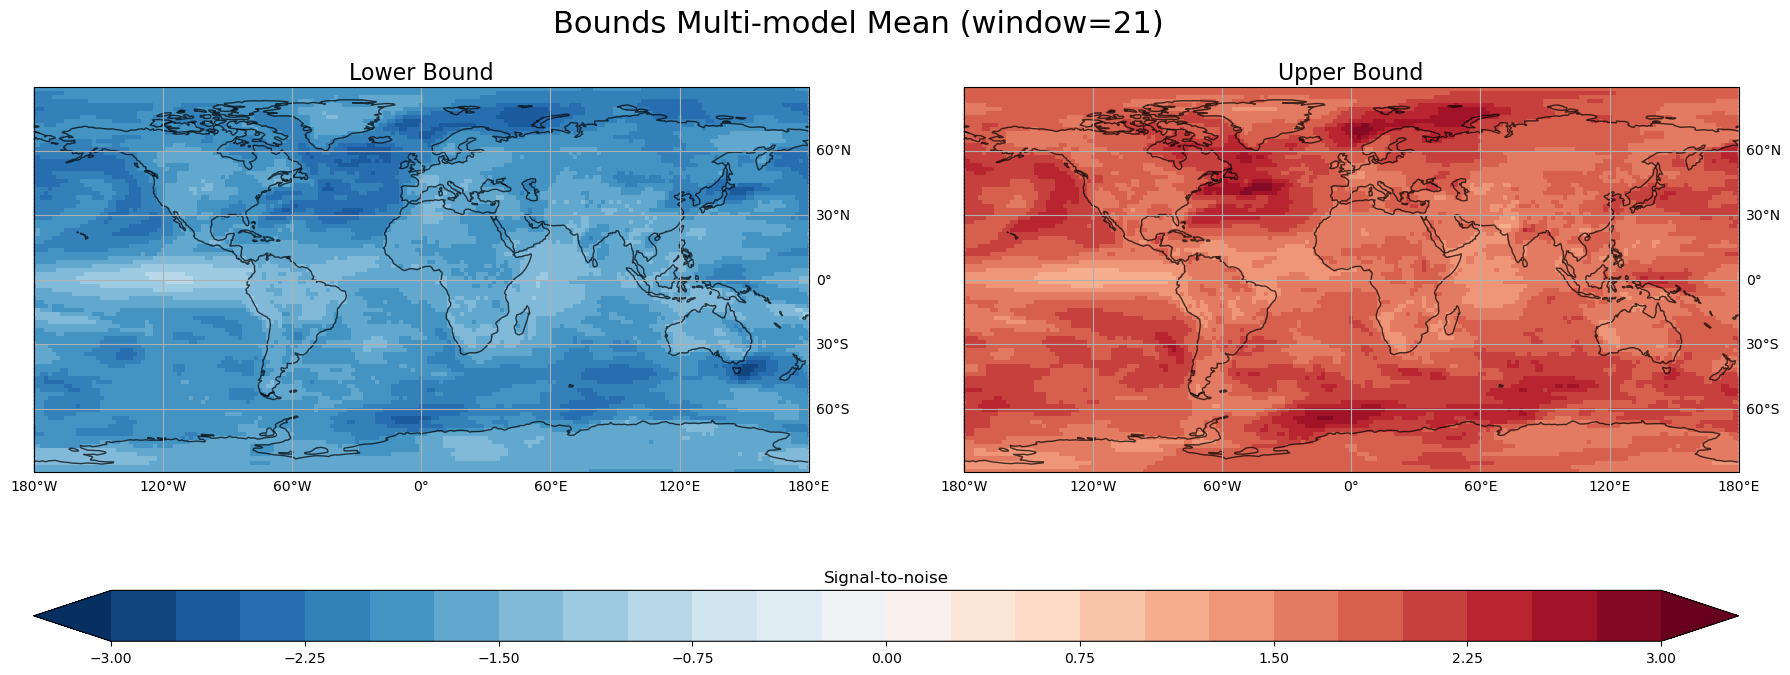

In [24]:
fig = plt.figure(figsize=(22,8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.1])
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())

plot_kwargs = dict( levels=levels, cmap='RdBu_r', add_colorbar=False, extend='both')
control__lbound_mm.sel(window=21).plot(ax=ax1, **plot_kwargs)
cplot = control__ubound_mm.sel(window=21).plot(ax=ax2, **plot_kwargs)

sn_plotting.format_plot(fig, ax1)
sn_plotting.format_plot(fig, ax2)

ax1.set_title('Lower Bound', fontsize=16)
ax2.set_title('Upper Bound', fontsize=16)
fig.suptitle('Bounds Multi-model Mean (window=21)', fontsize=22, y=0.9)


cax = plt.subplot(gs[1, :])
cbar = plt.colorbar(cplot, cax=cax, orientation='horizontal')
cbar.ax.set_title('Signal-to-noise')

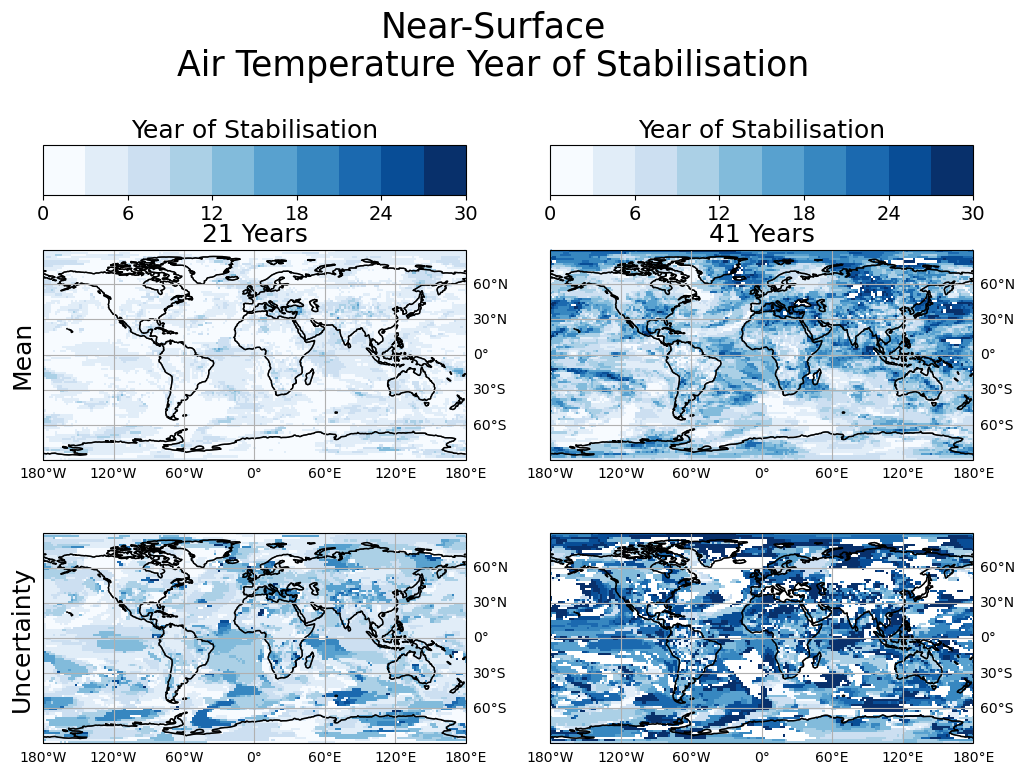

In [27]:
fig, axes, plots = sn_plotting.map_plot_all_for_coords(
    static_year_stable_local_average.squeeze().drop('variable').to_array(name='new'), column_coord='window',
    column_title_tag='Years', y=1.05, row_coord='variable', row_labels=['Mean', 'Uncertainty'],
    variable=experiment_params['variable'], extend='neither', cmap='Blues')

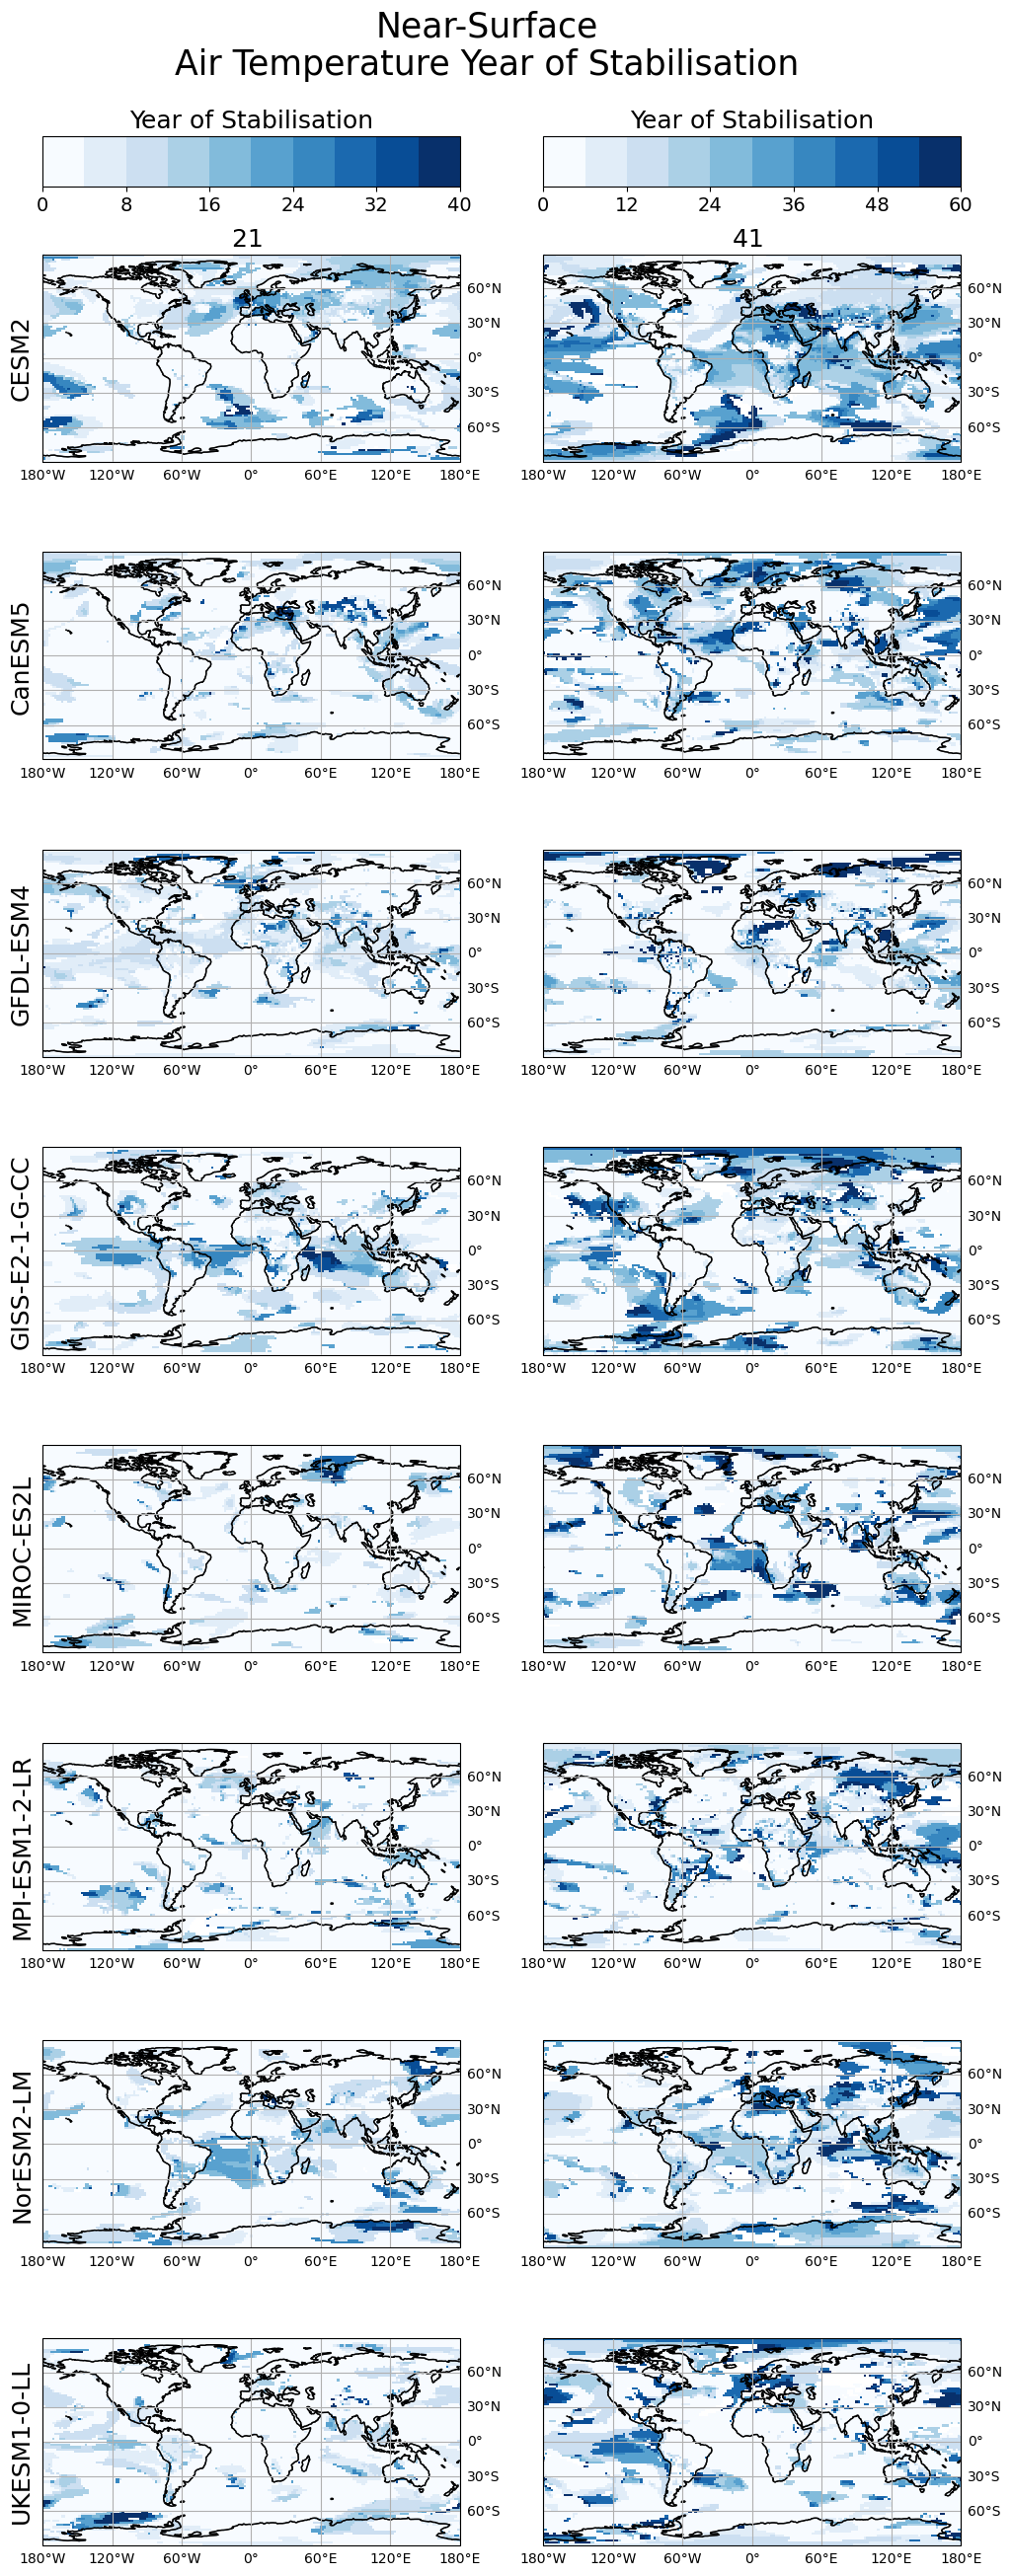

In [28]:
fig, axes, plots = sn_plotting.map_plot_all_for_coords(
    static_year_stable_local, column_coord='window', row_coord='model', y=0.92,
    variable=experiment_params['variable'], extend='neither', cmap='Blues')

# save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
#                          f'{notebook_number}_{variable}_all_model_year_of_stabilisation.png')
# print(save_name)
# fig.savefig(save_name, dpi = 200, bbox_inches='tight')

## Global

In [29]:
trend_da = stats.trend_fit(experiment_zec_ds_smean, method='polynomial', order=3)
detrended_da = experiment_zec_ds_smean - trend_da

In [30]:
sn_multi_static_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    experiment_zec_ds_smean, picontrol_zec_ds_smean,
    rolling_noise=False, da_for_noise = detrended_da, parallel=False,
    logginglevel='ERROR', return_all=True,
    **constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS)


Experiment
--------
11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge


In [33]:
sn_multi_rolling_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    experiment_zec_ds_smean, picontrol_zec_ds_smean,
    rolling_noise=True, da_for_noise = detrended_da, parallel=False,
    logginglevel='ERROR', return_all=True,
    **constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS)


Experiment
--------
11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge


In [34]:
# rolling_fraction_stable = sn.get_fracion_stable_ds(sn_multi_rolling_ds)
# static_fraction_stable = sn.get_fracion_stable_ds(sn_multi_static_ds)

# Number of models stable at each time step.
rolling_stability_levels_ds = sn.stability_levels(sn_multi_rolling_ds)
static_stability_levels_ds = sn.stability_levels(sn_multi_static_ds)

# Year when models first become stable.
rolling_year_stable = sn.get_stable_year_ds(sn_multi_rolling_ds)
static_year_stable = sn.get_stable_year_ds(sn_multi_static_ds)

Replacing points greater than 100 with 101
Replacing points greater than 90 with 91


# Plotting

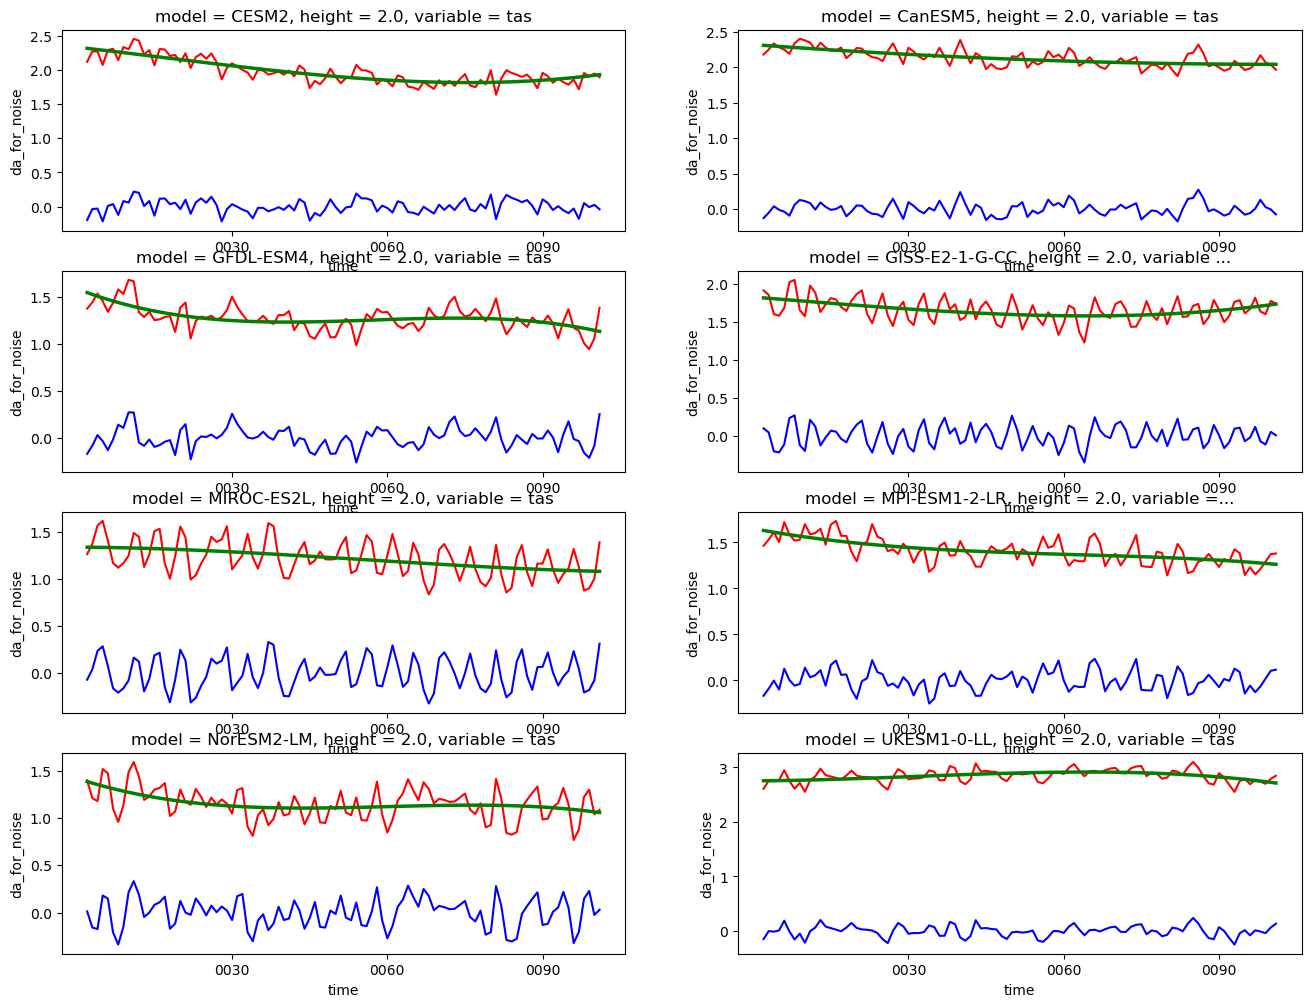

In [35]:
models = experiment_zec_ds_smean.model.values
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(8*ncols, 3*nrows))
for plot_num, model in enumerate(models):
    ax = fig.add_subplot(nrows,ncols,plot_num+1)
    experiment_zec_ds_smean.sel(model=model).plot(ax=ax, color='red')
    trend_da.sel(model=model).plot(ax=ax, linewidth=2.5, color='green')
    detrended_da.sel(model=model).plot(ax=ax, color='blue')

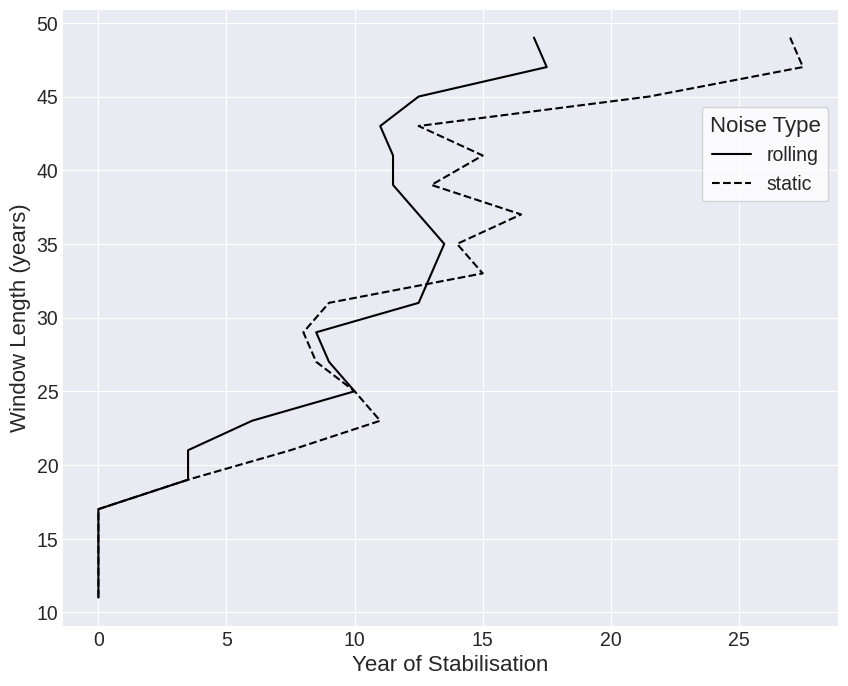

In [36]:
fig, ax = sn_plotting.plot_median_stable_year(static_year_stable, rolling_year_stable)

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         'zed_01_stabilisation_year_double_poly_vs_static.png'),
           dpi=300)

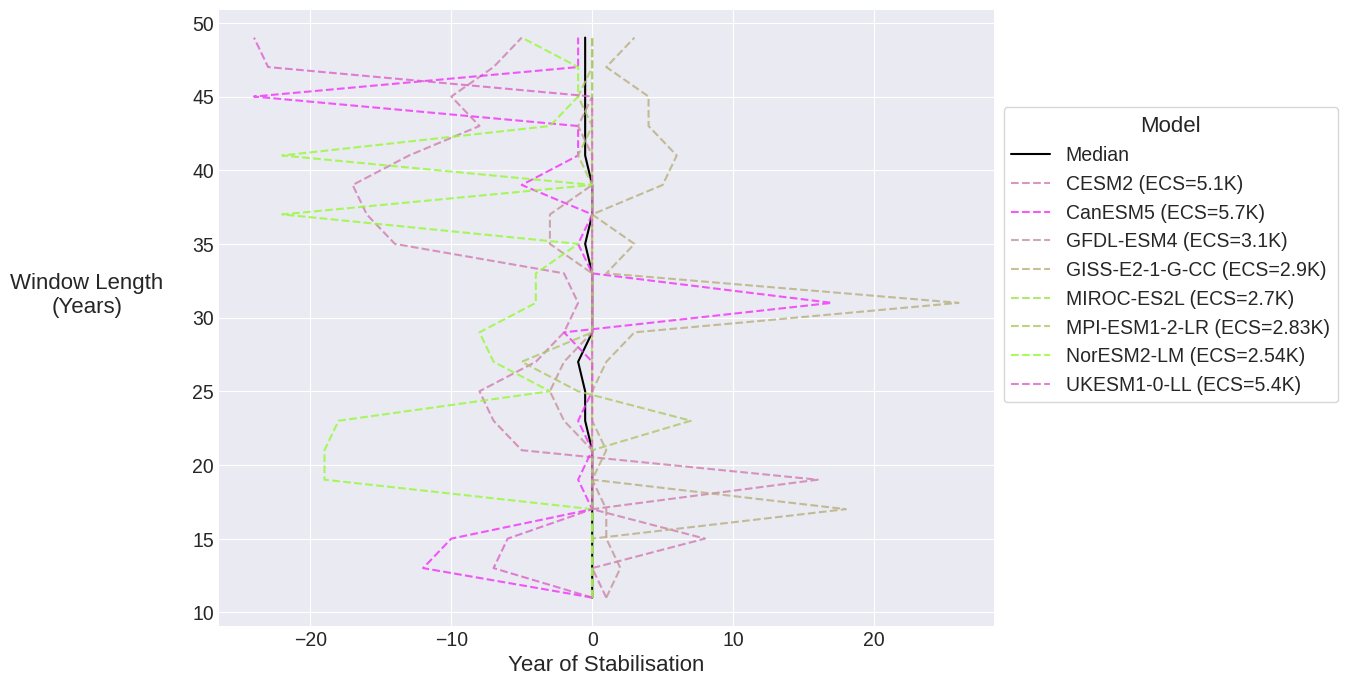

In [37]:
fig, ax = sn_plotting.plot_stable_year_all_models(static_year_stable-rolling_year_stable, exp_type='zecmip')

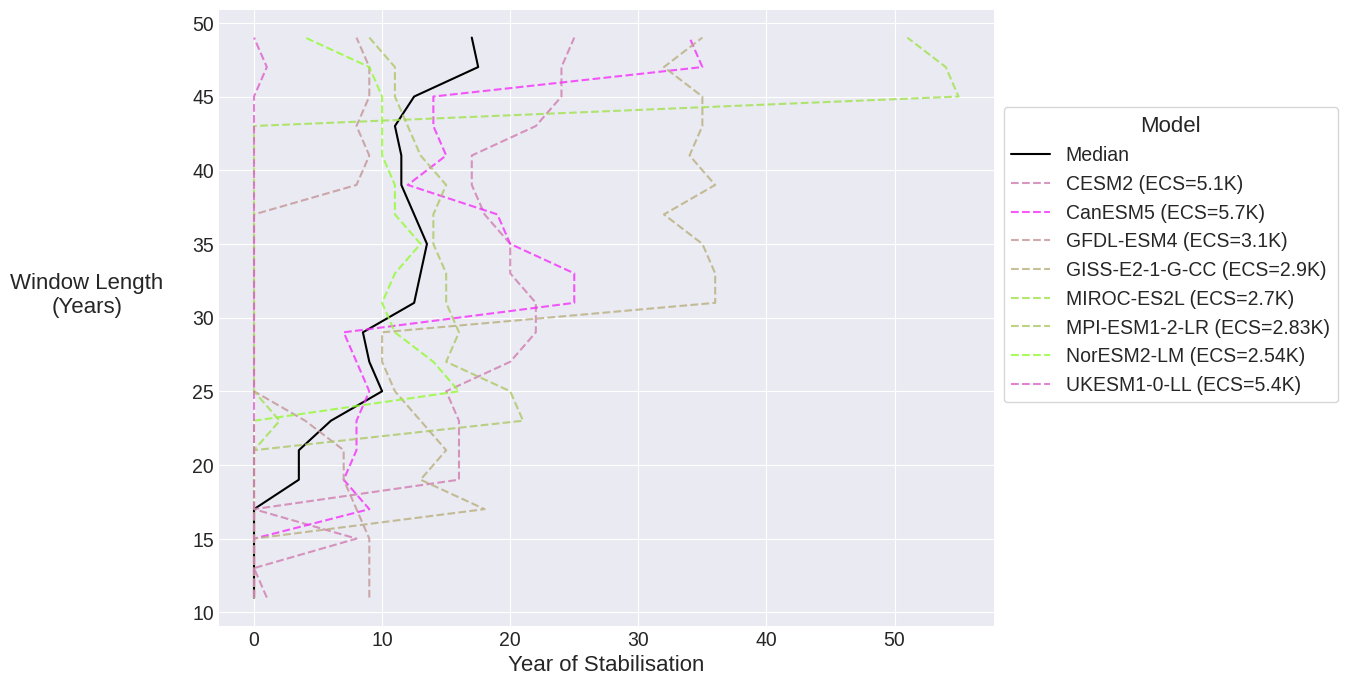

In [40]:
fig, ax = sn_plotting.plot_stable_year_all_models(static_year_stable, exp_type='zecmip')
# fig

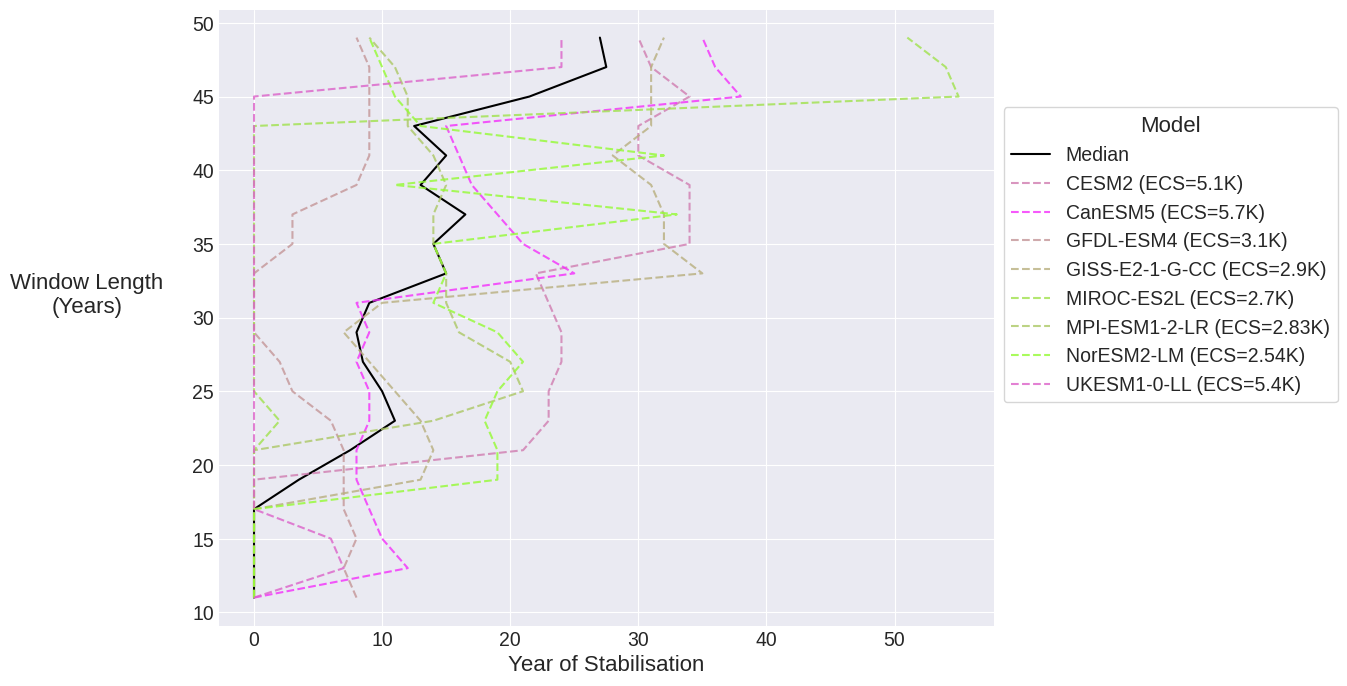

In [41]:
fig, ax = sn_plotting.plot_stable_year_all_models(rolling_year_stable, exp_type='zecmip')
# fig

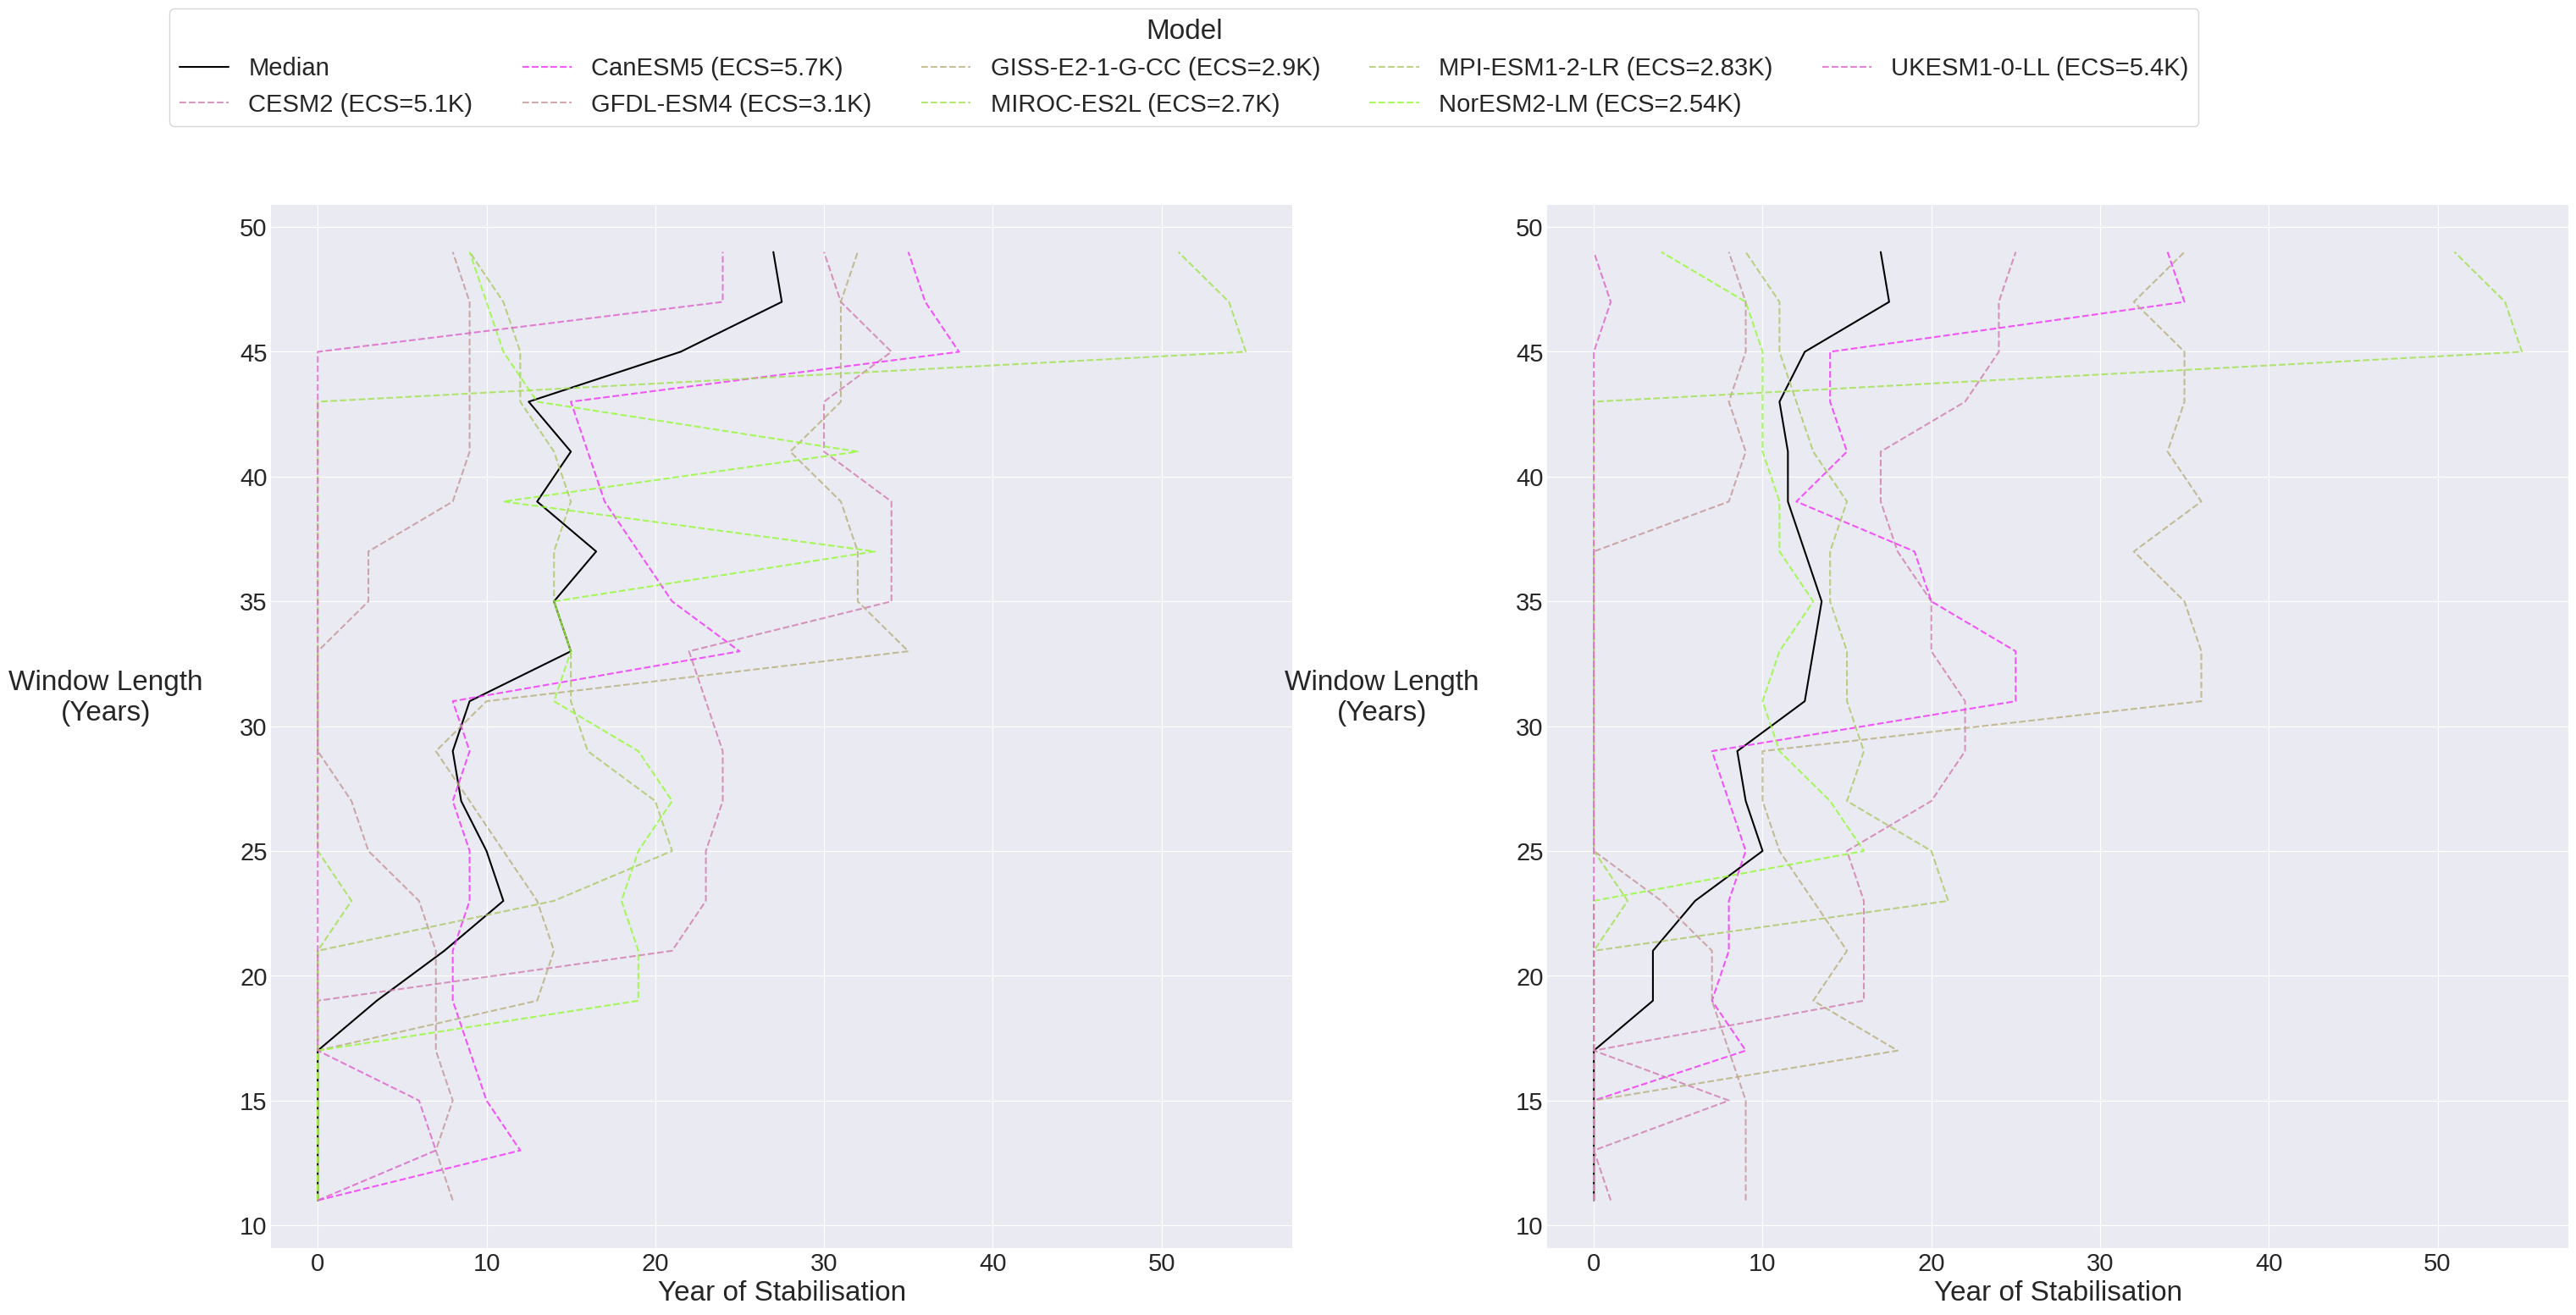

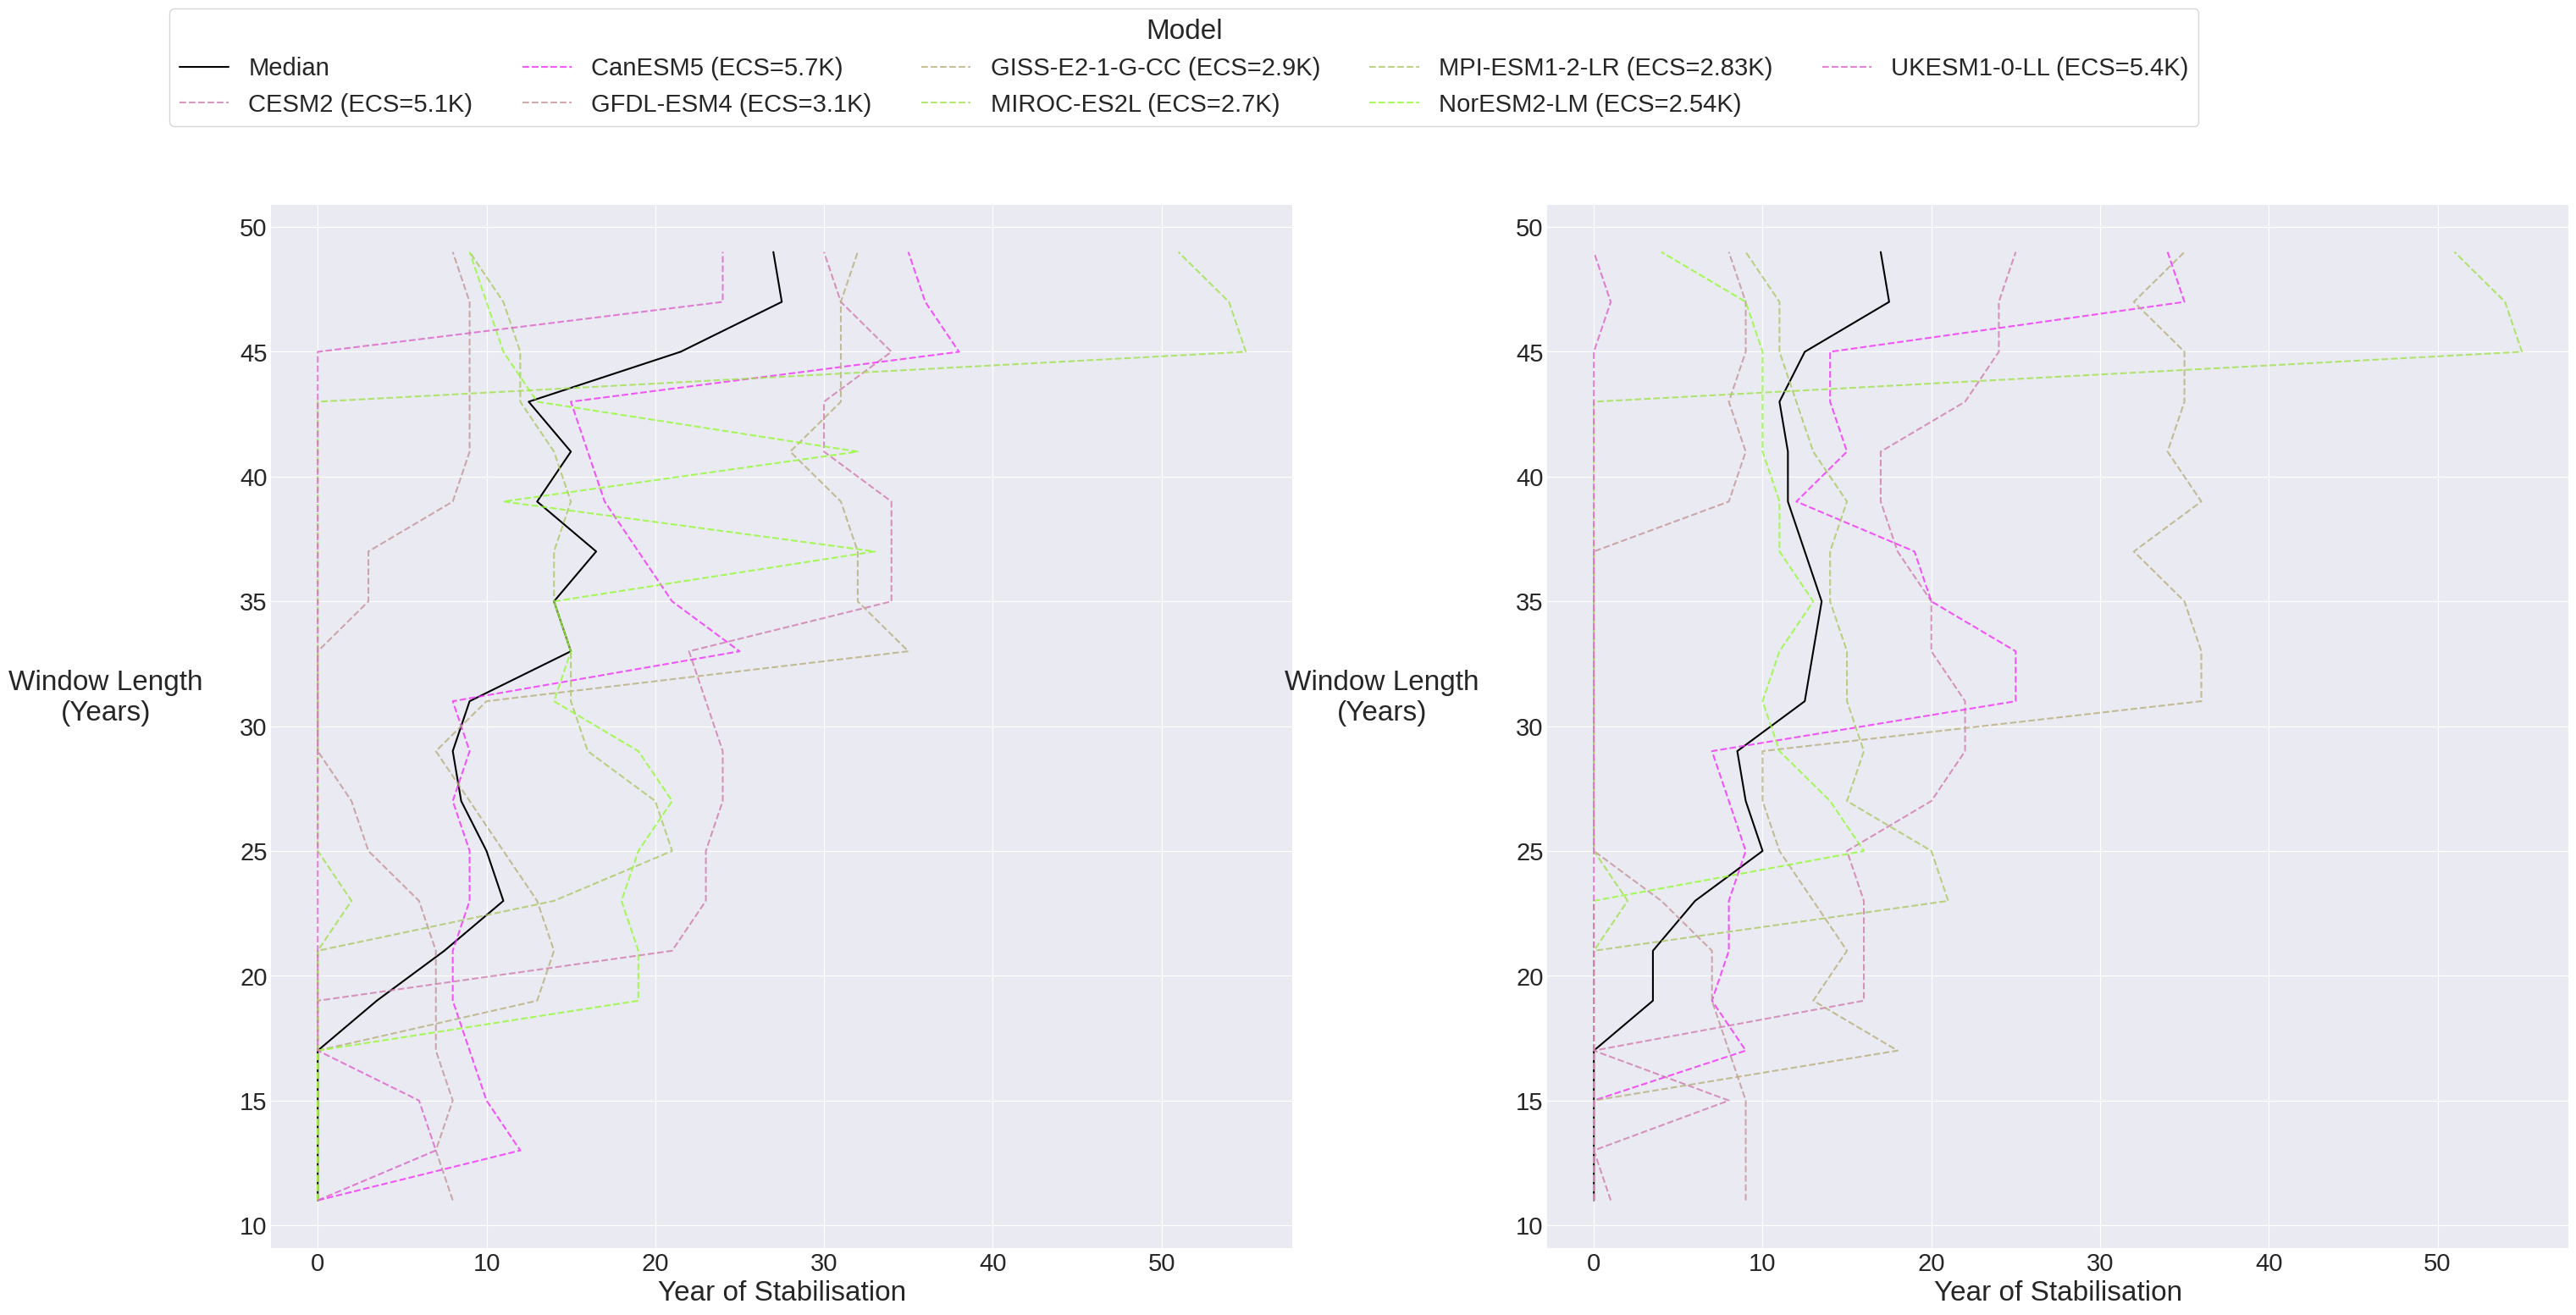

In [42]:
fig = plt.figure(figsize=(35, 16))
gs = gridspec.GridSpec(1,2, wspace=0.25)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
reload(sn_plotting)
fig, ax = sn_plotting.plot_stable_year_all_models(rolling_year_stable, exp_type='zecmip', ncol=5, 
                                                 fig=fig, ax=ax1, legend_loc = 'top_ofset',
                                                 bbox_to_anchor=(1.9, 1.2), font_scale=1.5)
fig, ax = sn_plotting.plot_stable_year_all_models(static_year_stable, exp_type='zecmip', 
                                                 fig=fig, ax=ax2, add_legend=False, font_scale=1.5)

fig

In [45]:
units = constants.VARIABLE_INFO[experiment_params["variable"]]["units"]
longname = constants.VARIABLE_INFO[experiment_params["variable"]]['longname']
hemisphere_title = string.capwords(experiment_params['hemisphere'].replace('_', ' '))
mask_title = f'({experiment_params["mask"]} only)' if experiment_params["mask"] else ''

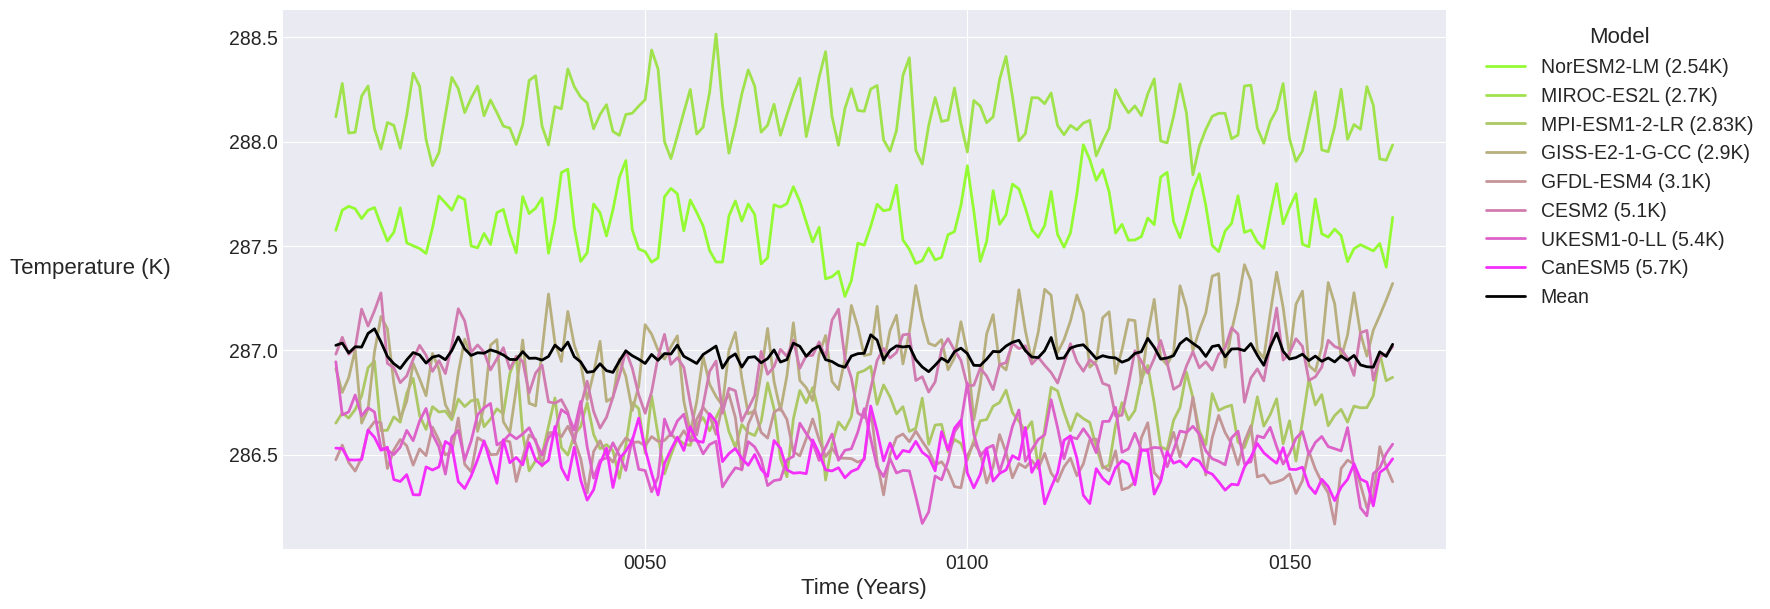

In [47]:
plt.style.use('seaborn-darkgrid')
fig, ax = sn_plotting.plot_all_coord_lines(picontrol_zec_ds_smean, exp_type='zecmip', xlabel='Time (Years)',
                              ylabel='Temperature (K)', ncol=1)
# fig

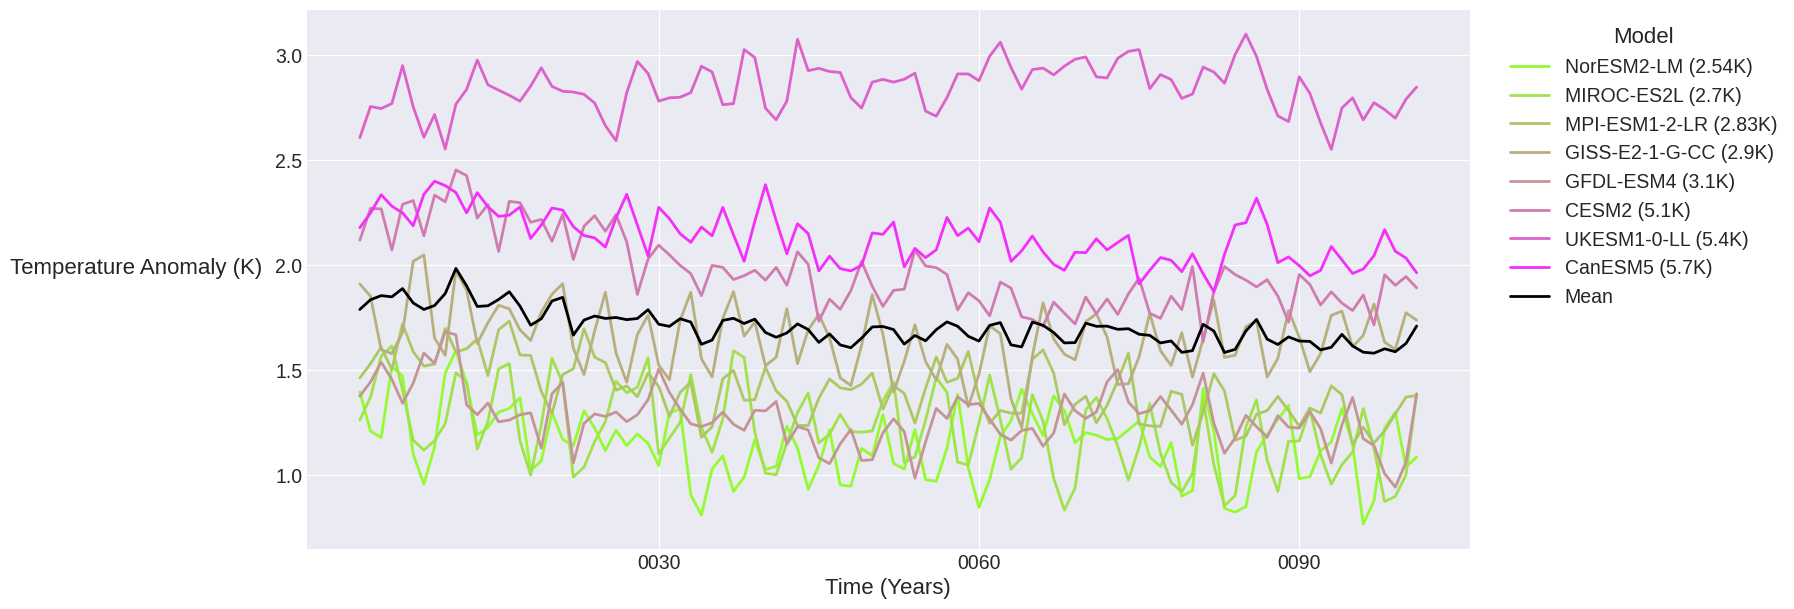

In [48]:
plt.style.use('seaborn-darkgrid')
fig, ax = sn_plotting.plot_all_coord_lines(experiment_zec_ds_smean, exp_type='zecmip',
                               xlabel='Time (Years)', ylabel='Temperature Anomaly (K)', ncol=1)
# fig

In [49]:
models = rolling_year_stable.model.values
levels = np.arange(0, len(models)+1,1)
my_blues = plotting_functions.create_discrete_cmap('Blues', levels=levels, add_white=True)
my_reds = plotting_functions.create_discrete_cmap('Reds', levels=levels, add_white=True)

plot_kwargs = dict(exp_type='zecmip',vmin=0, vmax=len(models)+1, step=1, tick_offset='center',
                   extend='neither', cbar_label='Number of Unstable Models')

comparison_kwargs = dict(max_color_lim=50, xlims=(0,50), font_scale=1.6)

{'levels': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}
{'levels': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}


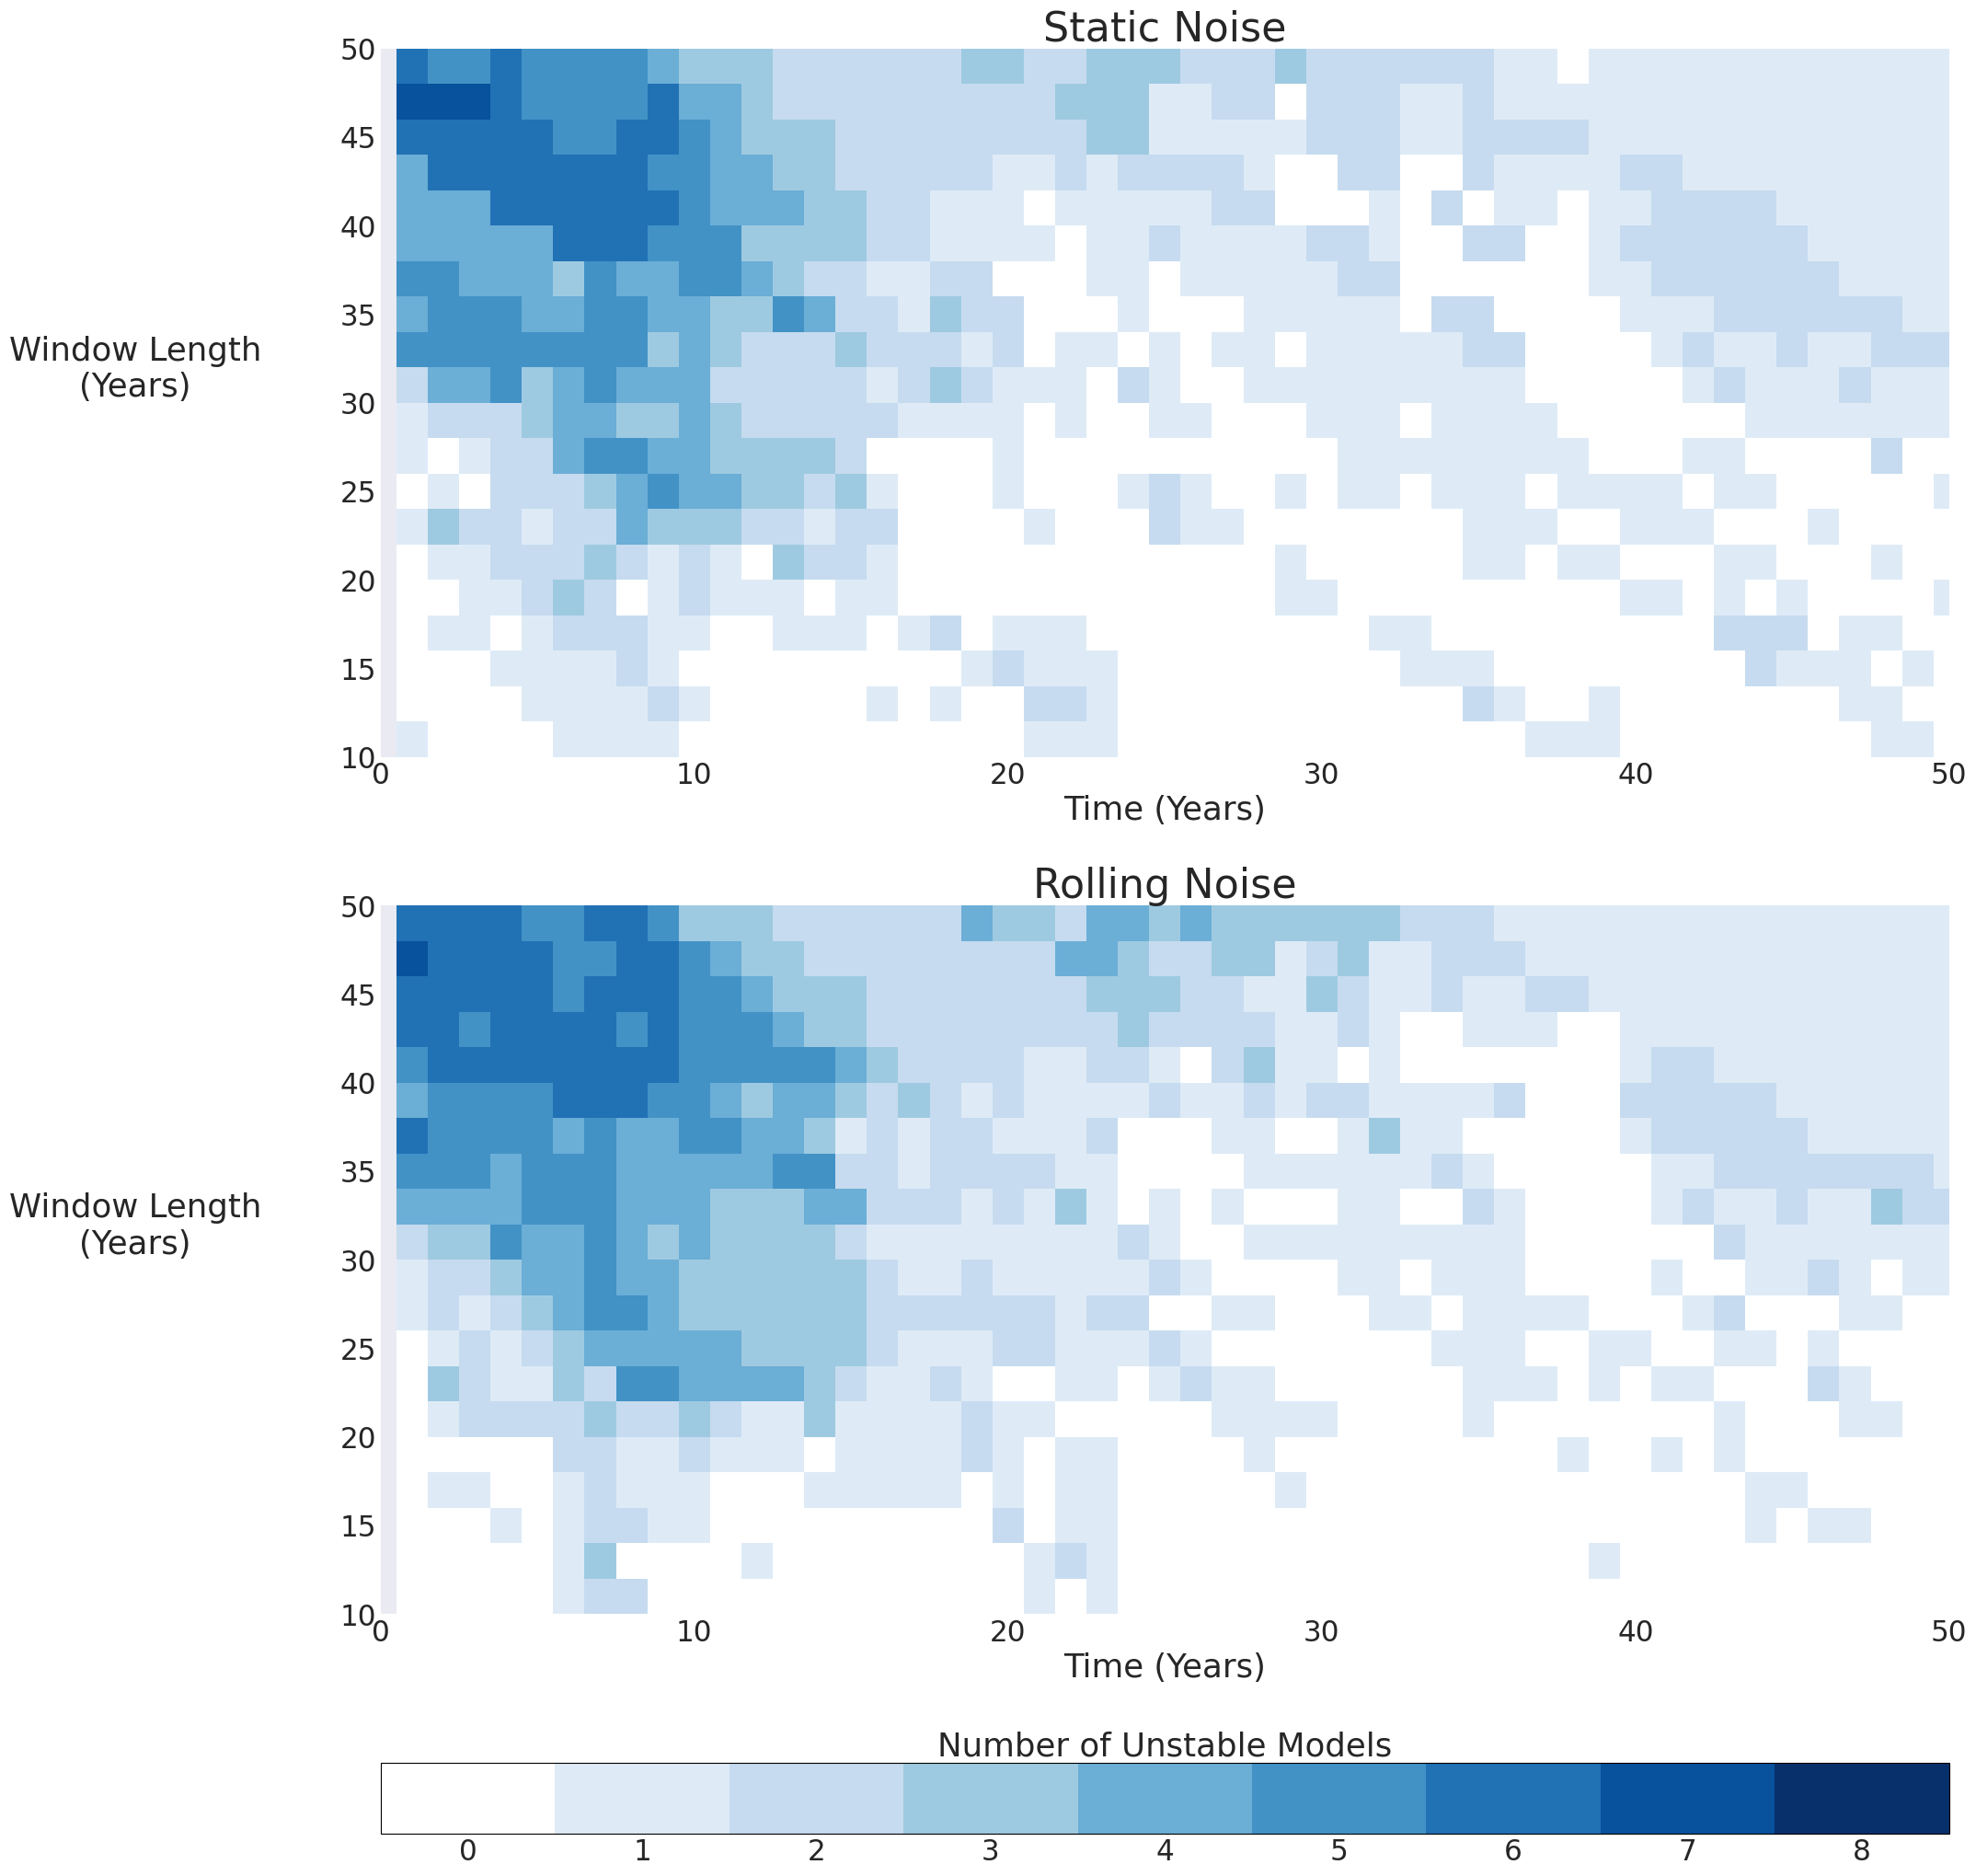

In [52]:
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'],
                          sn_plotting.plot_kwargs['height']*2.1))

gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 0.1], hspace=sn_plotting.plot_kwargs['hspace'])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sn_plotting.sn_multi_window_in_time(
    static_stability_levels_ds.sel(stability='unstable').count(dim='model'), cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False, axes_title='Static Noise',
    **plot_kwargs, **comparison_kwargs)

sn_plotting.sn_multi_window_in_time(
    rolling_stability_levels_ds.sel(stability='unstable').count(dim='model'), cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False, axes_title='Rolling Noise',
    **plot_kwargs, **comparison_kwargs)

In [53]:
stability_colorplot_kwargs = dict(max_color_lim=50, xlims=(0, 90),patch=True,
                                  ax2_ylabel=f'Global Mean\n{longname}\nAnomaly({units})')

In [55]:
%matplotlib inline

{'levels': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}
{'levels': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}


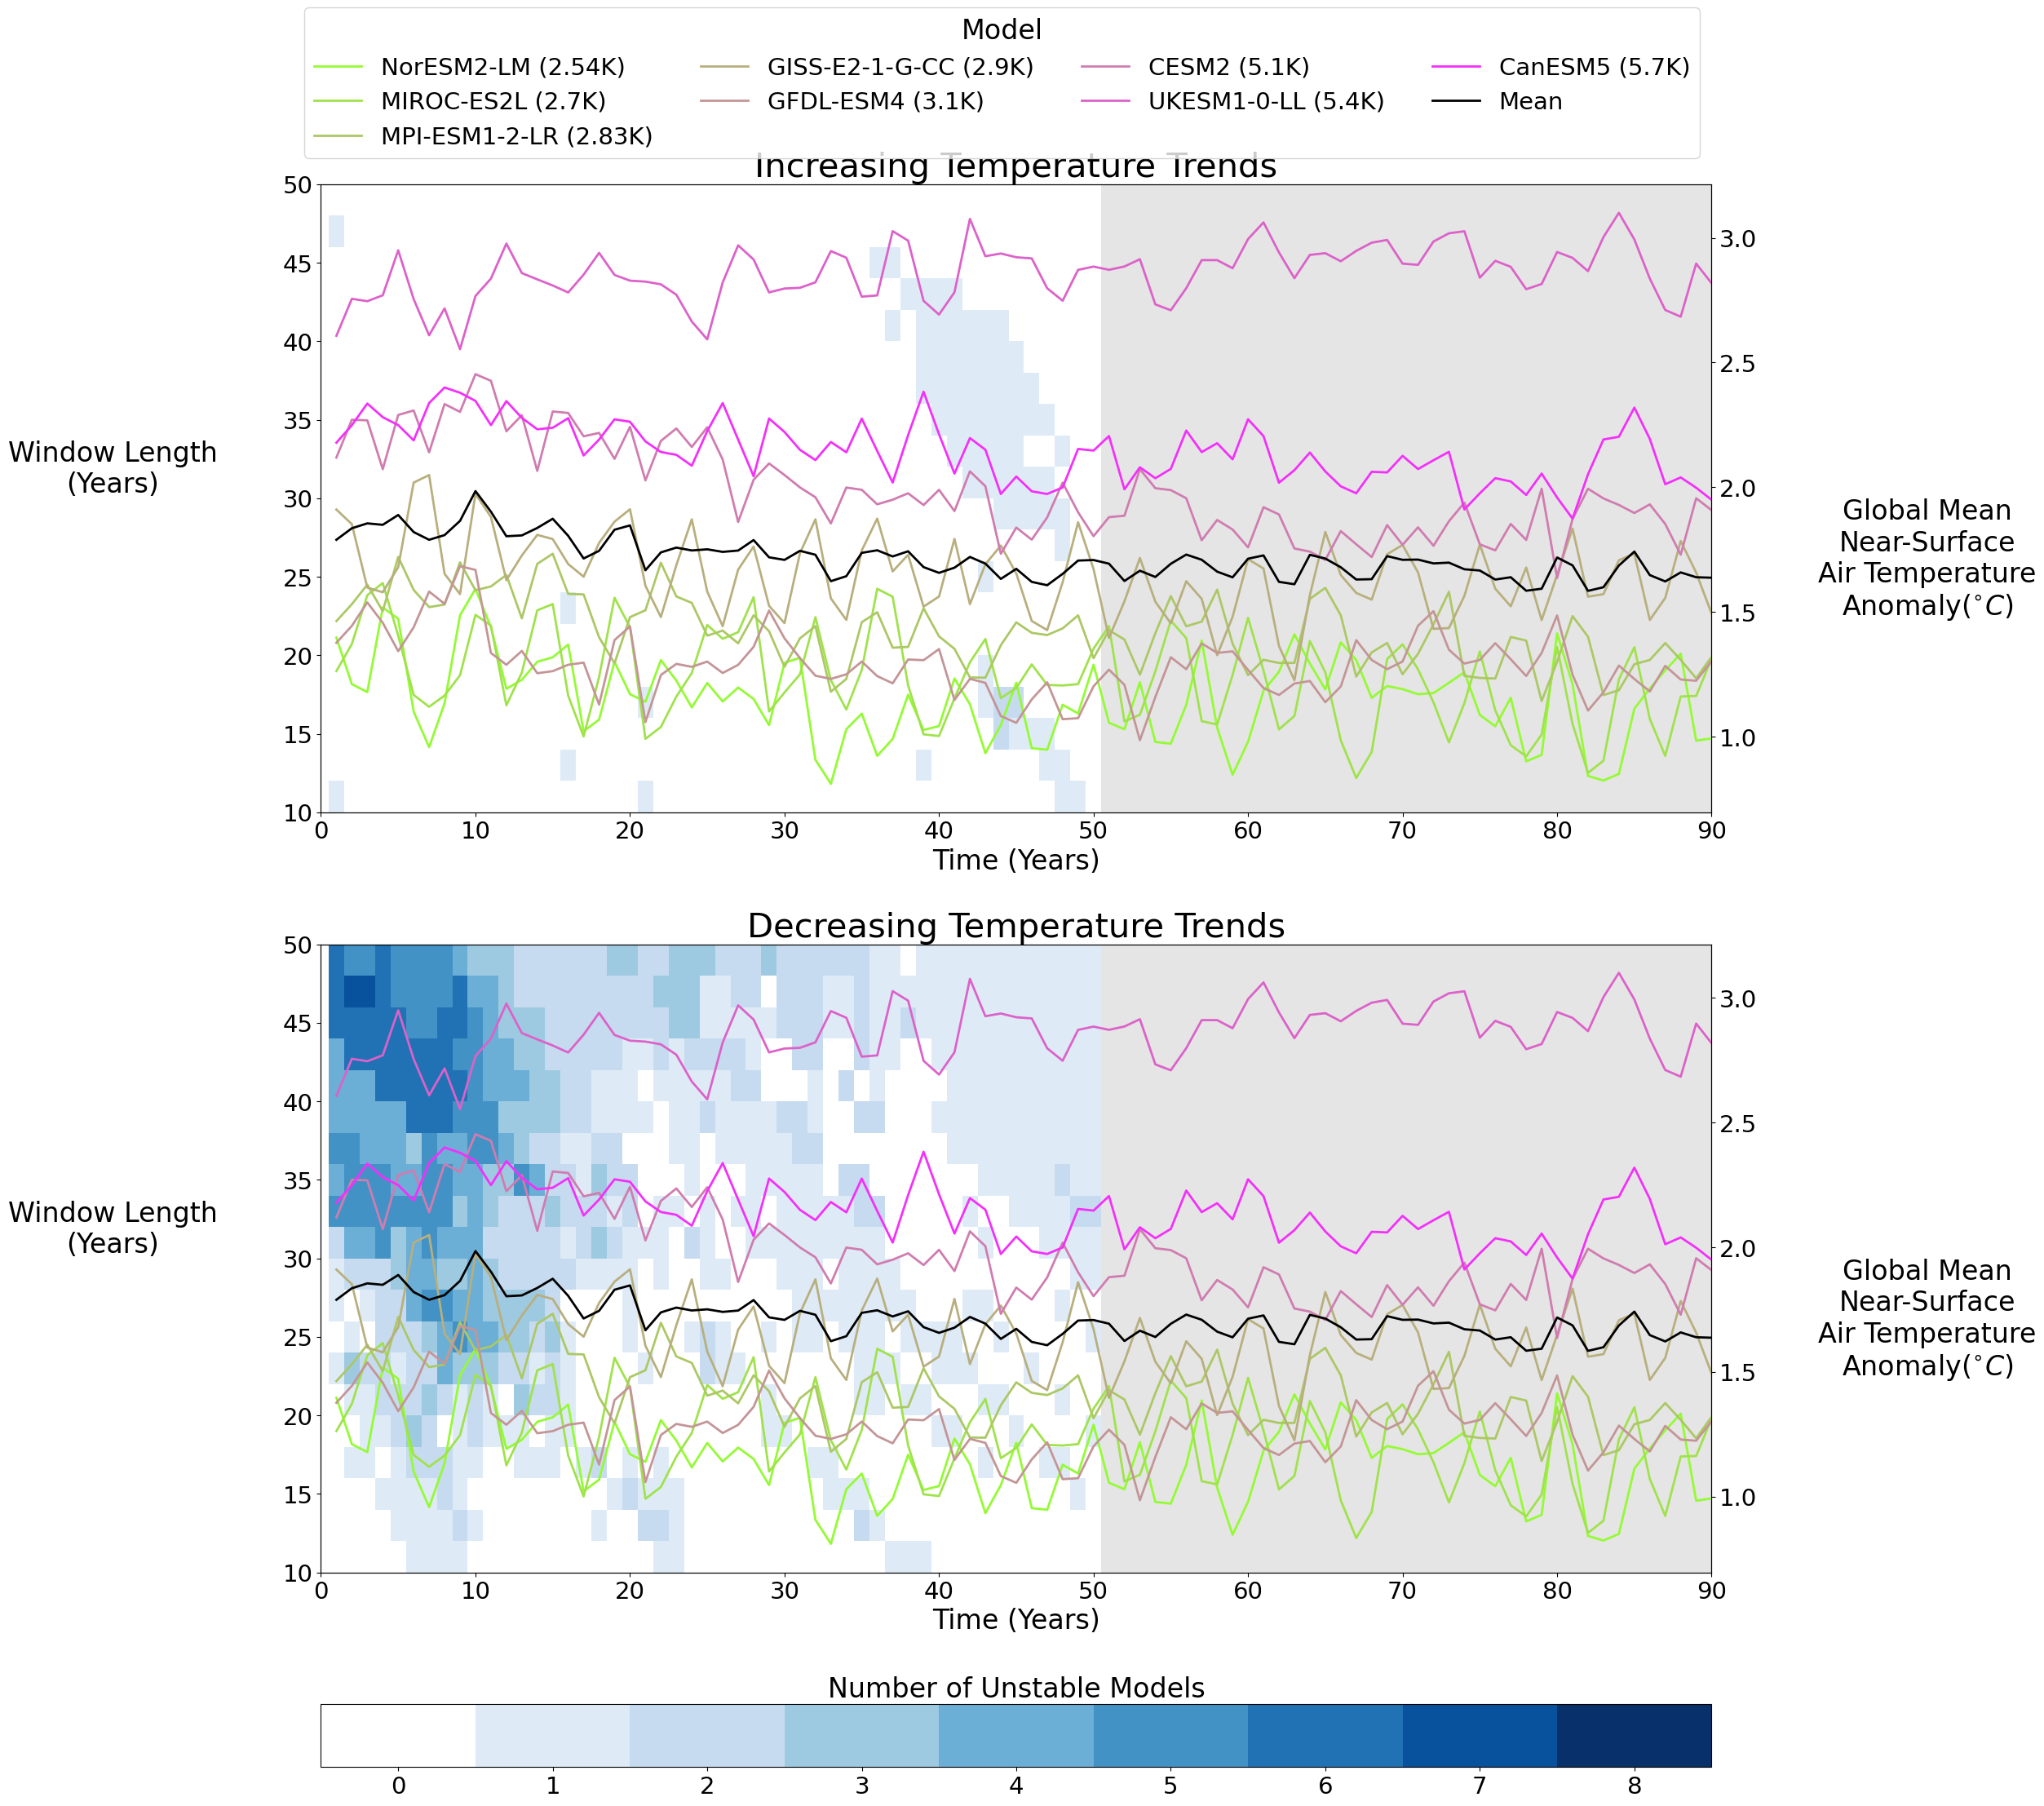

In [58]:
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*2.1))

gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 0.1], hspace=sn_plotting.plot_kwargs['hspace'])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sn_plotting.sn_multi_window_in_time(
    static_stability_levels_ds.sel(stability='increasing').count(dim='model'), cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='Increasing Temperature Trends', 
    temp_da=experiment_zec_ds_smean,  **stability_colorplot_kwargs,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    static_stability_levels_ds.sel(stability='decreasing').count(dim='model'), cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='Decreasing Temperature Trends',
    add_legend=False,
    temp_da=experiment_zec_ds_smean, **stability_colorplot_kwargs,  **plot_kwargs)

{'levels': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}


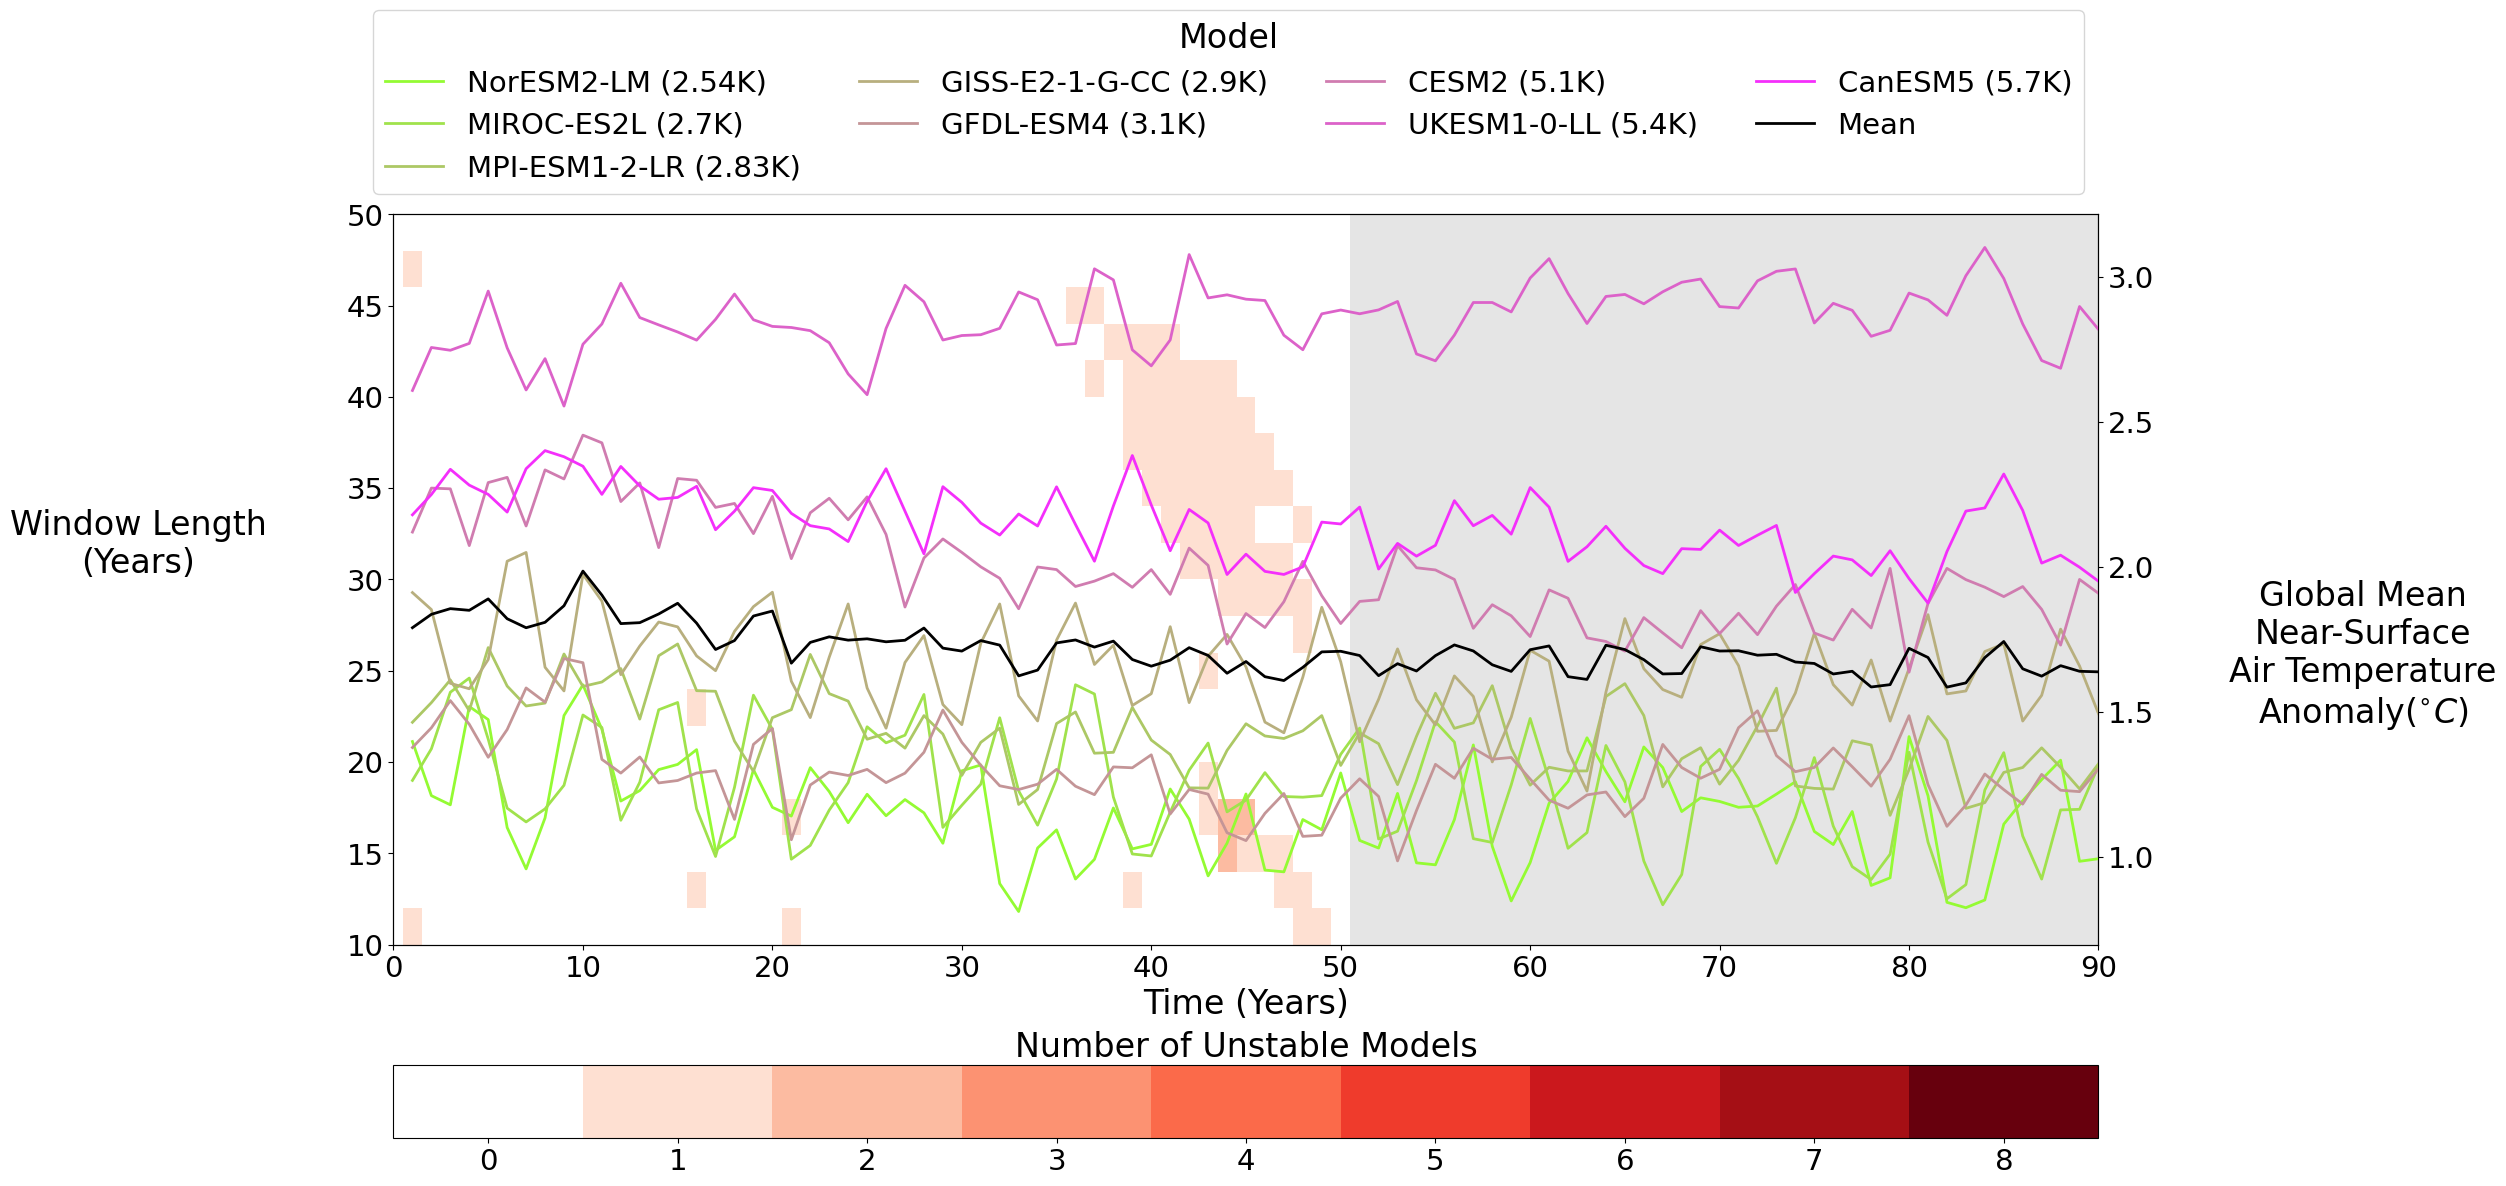

In [60]:
fig, axes = sn_plotting.sn_multi_window_in_time(
    static_stability_levels_ds.sel(stability='increasing').count(dim='model'),
    temp_da=experiment_zec_ds_smean, cmap=my_reds, **stability_colorplot_kwargs,  **plot_kwargs)
fig

{'levels': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}


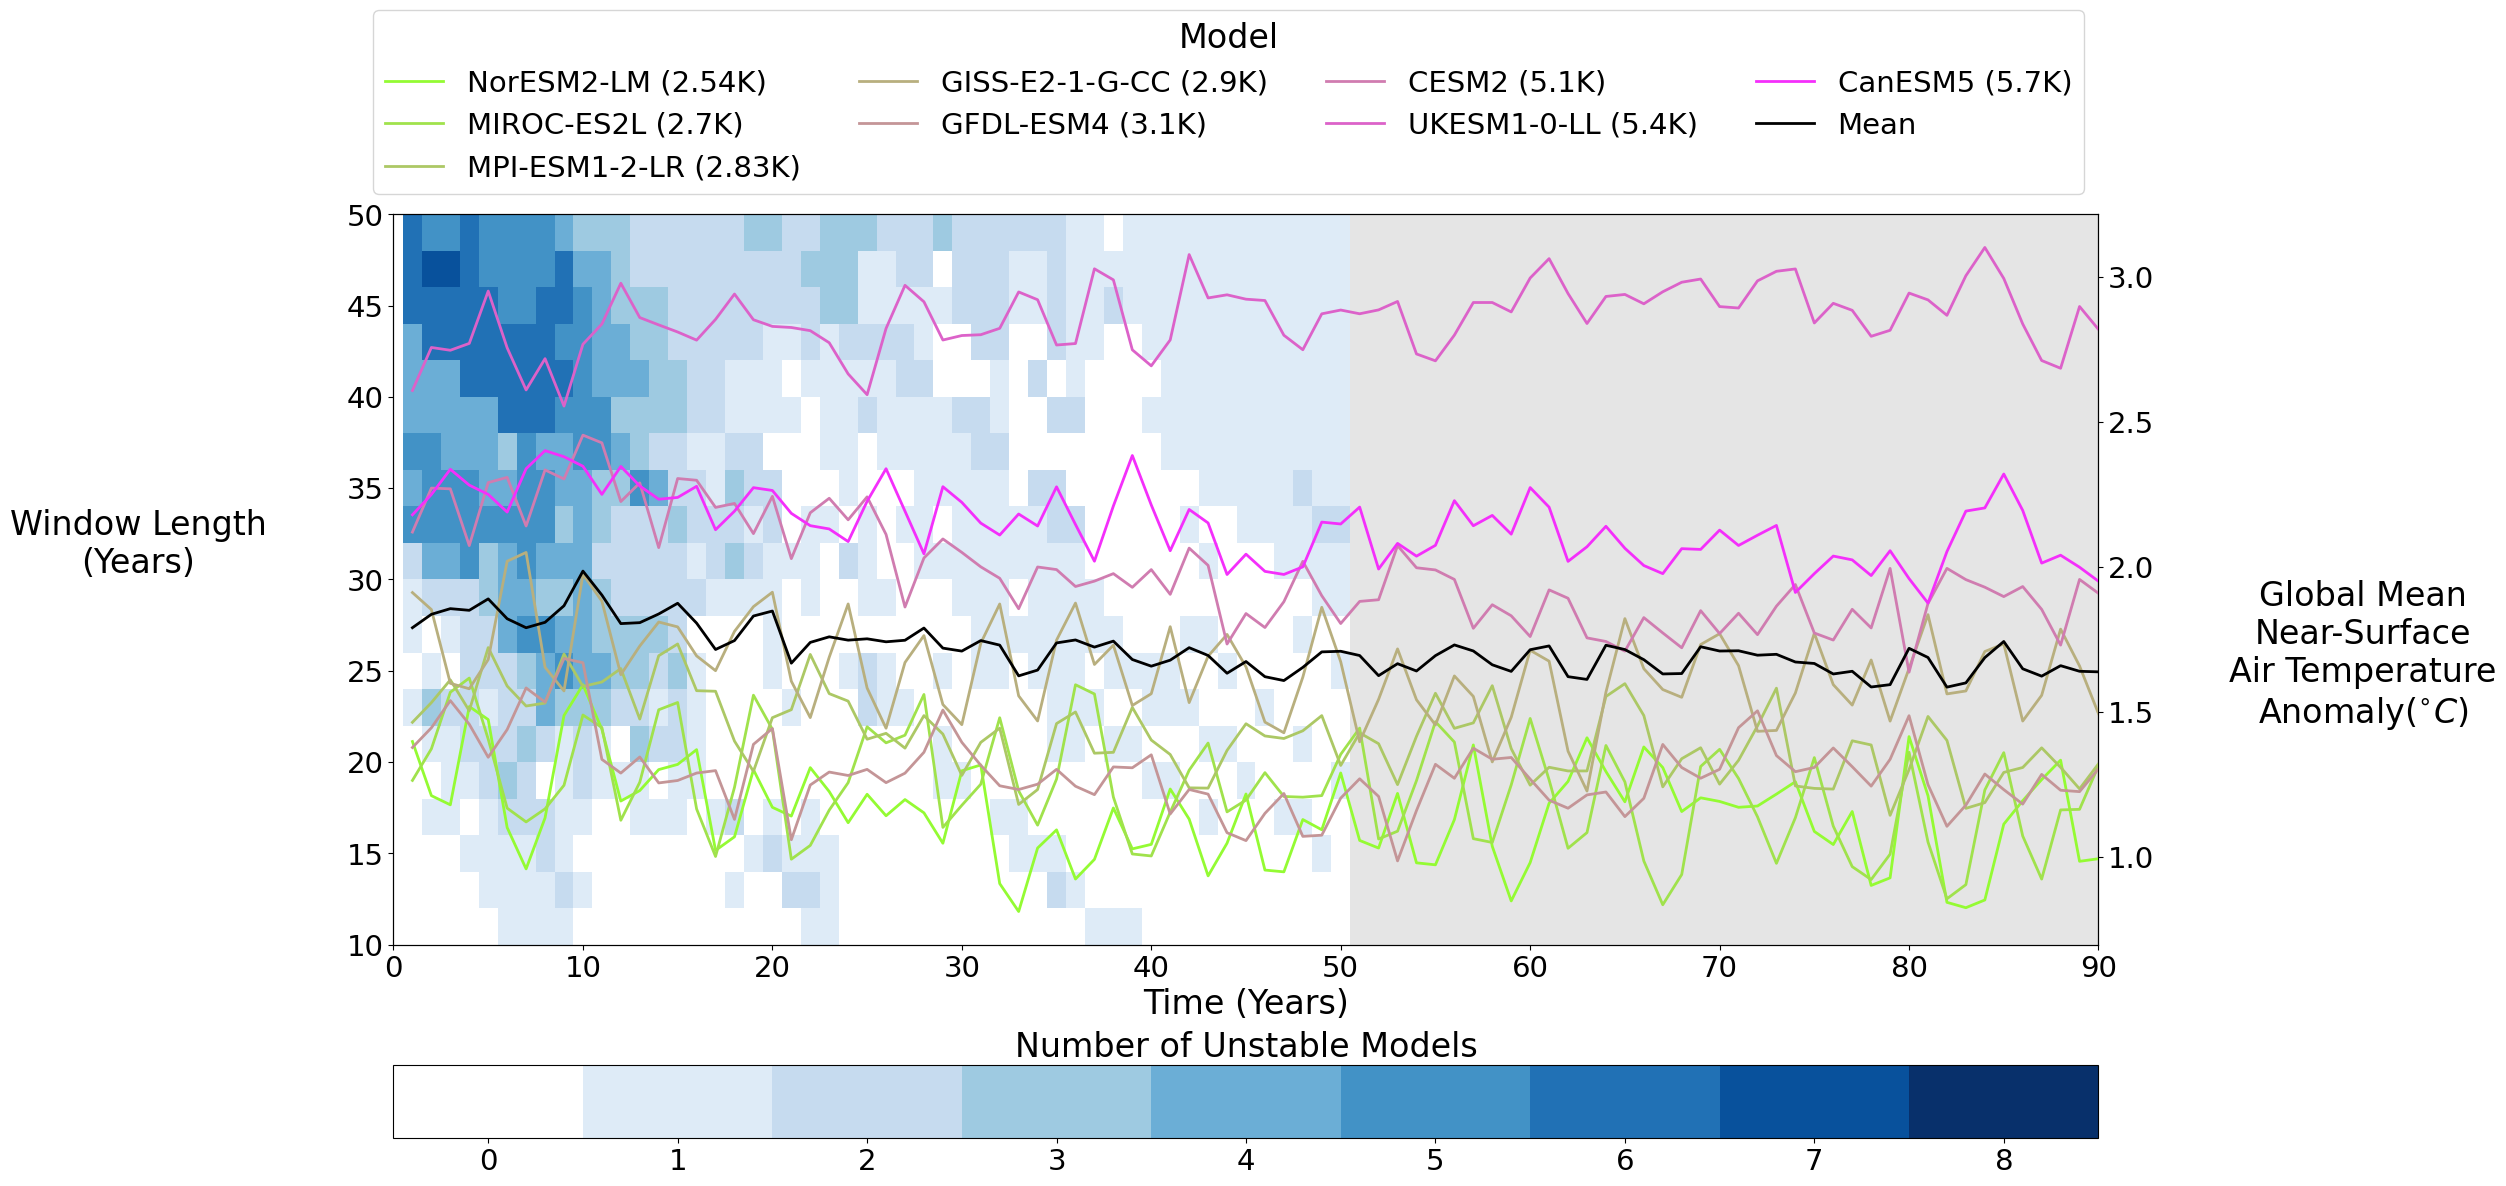

In [62]:
fig, axes = sn_plotting.sn_multi_window_in_time(
    static_stability_levels_ds.sel(stability='decreasing').count(dim='model'),
    temp_da=experiment_zec_ds_smean, cmap=my_blues, **stability_colorplot_kwargs,  **plot_kwargs)

fig

In [64]:
sn_levels = sn_plotting.create_levels(vmax=.13, vmin=0.1, step=.002)

In [66]:
%matplotlib inline

{'levels': array([0.1  , 0.102, 0.104, 0.106, 0.108, 0.11 , 0.112, 0.114, 0.116,
       0.118, 0.12 , 0.122, 0.124, 0.126, 0.128, 0.13 ])}


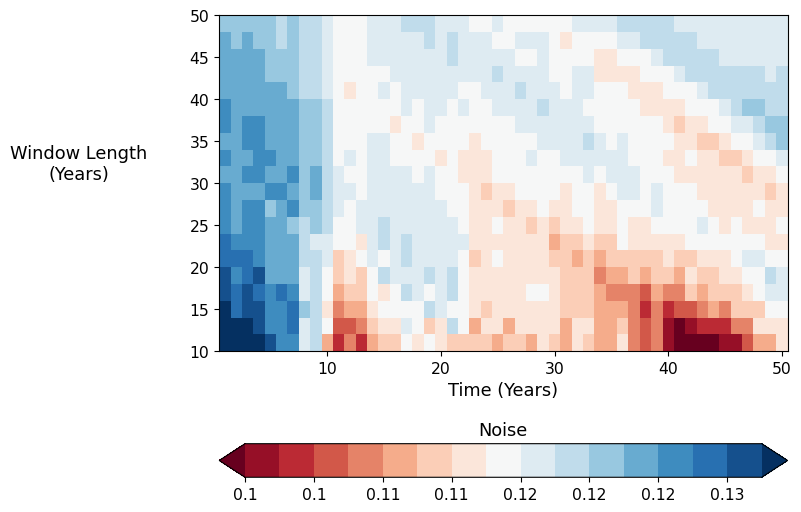

In [67]:
sn_plotting.plot_heatmap(sn_multi_rolling_ds.noise.mean(dim='model'), levels=sn_levels, 
                                figsize=(sn_plotting.plot_kwargs['width']/3,
                                         sn_plotting.plot_kwargs['height']/2), 
                               cmap='RdBu', extend='both', cut_ticks=2, max_color_lim=50, 
                               font_scale=0.8, cbar_label='Noise', hspace=0.2, return_all=False)

In [68]:
percent_frac = sn_multi_rolling_ds.noise*100/sn_multi_static_ds.noise
diff = sn_multi_rolling_ds.noise - sn_multi_static_ds.noise
percent_diff = diff * 100/sn_multi_rolling_ds.noise

In [ ]:
# plot_kwargs_2 = dict(height=12, width=22, hspace=0.3, #vmin=-8, vmax=8, step=2, 
#                    cmap = 'RdBu_r', line_color = 'limegreen', line_alpha=0.65, 
#                    ax2_ylabel = 'Anomaly', cbar_label = 'Signal-to-Noise', cbartick_offset=0,
#                    axes_title='',
#                    title='', label_size=12, extend='both', xlowerlim=None, xupperlim=None,  filter_max=True,)